In [ ]:
!pip install prophet
!pip install pyspark
!pip install pyarrow
!pip install -U -q PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=2d2e400f25e0b4f38d271095608e47b96aa5a2f6761aa4d5659bbea05d1903af
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_list = drive.ListFile({'q': "'1WEWMdTfmeKD-tFrXrOlTtFkKhnoL_fU6' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

In [ ]:
id='13bxB3TO8Q8yK3qxAQql_Sltm1npK7yZJ'
downloaded = drive.CreateFile({'id': id})
glt = downloaded.GetContentFile('GlobalLandTemperaturesByCountry.csv')
glt

 **PROJECT TITLE:  A Comparative Data Exploration and Time Series Analysis on Global Average Land Temperature by Selected Countries Using ARIMA Application to develop Predictive Model for Future Years.**

### DATA PREPROCESSING



In [ ]:
#Checking the python version
!python --version


Python 3.10.12


# Loading the required libraries and modules.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import current_date
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark import SparkContext, SparkConf

from prophet import Prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

from sklearn.preprocessing import MinMaxScaler

#Set plot size
rcParams["figure.figsize"] = 8, 5


In [ ]:
spark = SparkSession.builder.master("local").getOrCreate()
spark

In [ ]:
#Reading the dataset
glt = pd.read_csv("/content/GlobalLandTemperaturesByCountry.csv")

In [ ]:
glt_spark = glt
spark_glt = spark.createDataFrame(glt_spark)     #Creating Dataframe
spark_glt.printSchema()     #data type of each column
spark_glt.show()
spark_glt.count()    #No. of records


root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)

+----------+-------------------+-----------------------------+-------+
|        dt| AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+-------------------+-----------------------------+-------+
|1743-11-01|              4.384|                        2.294|  Åland|
|1743-12-01|                NaN|                          NaN|  Åland|
|1744-01-01|                NaN|                          NaN|  Åland|
|1744-02-01|                NaN|                          NaN|  Åland|
|1744-03-01|                NaN|                          NaN|  Åland|
|1744-04-01|               1.53|                         4.68|  Åland|
|1744-05-01|  6.702000000000001|                        1.789|  Åland|
|1744-06-01| 11.609000000000002|                        1.577|  Åland|
|1744-07-01|             15.3

577462

In [ ]:
#Checking the dataset info
glt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [ ]:
#The shape of the dataset
print("The shape of the dataset", glt.shape)

The shape of the dataset (577462, 4)


In [ ]:
# Viewing the datatype
print(glt.dtypes)

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object


In [ ]:
from IPython.utils.py3compat import cast_unicode
#Viewing the unique countries in the dataset to check for any anomalies
ct_unique = glt["Country"].unique()
print(ct_unique)

ct =glt["Country"].value_counts()

Avt= glt["AverageTemperature"].unique()
AvtU = glt["AverageTemperatureUncertainty"].unique()
print(Avt)
print(AvtU)


['Åland' 'Afghanistan' 'Africa' 'Albania' 'Algeria' 'American Samoa'
 'Andorra' 'Angola' 'Anguilla' 'Antarctica' 'Antigua And Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Asia' 'Australia' 'Austria' 'Azerbaijan'
 'Bahamas' 'Bahrain' 'Baker Island' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia'
 'Bonaire, Saint Eustatius And Saba' 'Bosnia And Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Bulgaria' 'Burkina Faso' 'Burma'
 'Burundi' "Côte D'Ivoire" 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Christmas Island' 'Colombia' 'Comoros'
 'Congo (Democratic Republic Of The)' 'Congo' 'Costa Rica' 'Croatia'
 'Cuba' 'Curaçao' 'Cyprus' 'Czech Republic' 'Denmark (Europe)' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Europe'
 'Falkland Islands (Islas Malvinas)' 'Faroe Islands'
 'Federated States Of

In [ ]:
from IPython.core.interactiveshell import get_default_colors
#Extracting the needed countries and the years for my analysis
glt_country = ["United Kingdom", "United States", "Brazil", "Kenya", "India"]
df_glt = glt[glt["Country"].isin(glt_country)]
df_glt

dt  AverageTemperature  AverageTemperatureUncertainty  \
77110   1832-01-01              24.935                          1.372   
77111   1832-02-01              24.505                          1.953   
77112   1832-03-01              24.617                          1.359   
77113   1832-04-01              23.990                          2.013   
77114   1832-05-01              23.124                          1.592   
...            ...                 ...                            ...   
557816  2013-05-01              14.073                          0.178   
557817  2013-06-01              20.198                          0.236   
557818  2013-07-01              22.074                          0.152   
557819  2013-08-01              21.168                          0.249   
557820  2013-09-01              18.273                          1.210   

              Country  
77110          Brazil  
77111          Brazil  
77112          Brazil  
77113          Brazil  
77114          Brazil  
...               ...  
557816  United States  
557817  United States  
557818  United States  
557819  United States  
557820  United States  

[12939 rows x 4 columns]

In [ ]:
#Converting the date to pandas datetime
df_glt["dt"] = pd.to_datetime(df_glt["dt"])


<ipython-input-15-268db881e809>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glt["dt"] = pd.to_datetime(df_glt["dt"])


In [ ]:
#Renaming the dt column name
df_glt.rename(columns = {"dt": "Date"}, inplace = True)
df_glt

<ipython-input-16-2e7bb1c53eda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glt.rename(columns = {"dt": "Date"}, inplace = True)


Date  AverageTemperature  AverageTemperatureUncertainty  \
77110  1832-01-01              24.935                          1.372   
77111  1832-02-01              24.505                          1.953   
77112  1832-03-01              24.617                          1.359   
77113  1832-04-01              23.990                          2.013   
77114  1832-05-01              23.124                          1.592   
...           ...                 ...                            ...   
557816 2013-05-01              14.073                          0.178   
557817 2013-06-01              20.198                          0.236   
557818 2013-07-01              22.074                          0.152   
557819 2013-08-01              21.168                          0.249   
557820 2013-09-01              18.273                          1.210   

              Country  
77110          Brazil  
77111          Brazil  
77112          Brazil  
77113          Brazil  
77114          Brazil  
...               ...  
557816  United States  
557817  United States  
557818  United States  
557819  United States  
557820  United States  

[12939 rows x 4 columns]

In [ ]:
#Extracting the years and months from 1900 to 2015
date_col = pd.DatetimeIndex(df_glt["Date"])
df_glt["Year"] = date_col.year
date_colm = pd.DatetimeIndex(df_glt["Date"])
df_glt["Month"] = date_colm.month


df_glt = df_glt[df_glt["Year"].between(1900, 2015)]
df_glt

<ipython-input-17-8460f42ff572>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glt["Year"] = date_col.year
<ipython-input-17-8460f42ff572>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glt["Month"] = date_colm.month


Date  AverageTemperature  AverageTemperatureUncertainty  \
77926  1900-01-01              25.086                          0.657   
77927  1900-02-01              25.259                          0.573   
77928  1900-03-01              25.835                          0.605   
77929  1900-04-01              24.602                          0.799   
77930  1900-05-01              24.393                          1.133   
...           ...                 ...                            ...   
557816 2013-05-01              14.073                          0.178   
557817 2013-06-01              20.198                          0.236   
557818 2013-07-01              22.074                          0.152   
557819 2013-08-01              21.168                          0.249   
557820 2013-09-01              18.273                          1.210   

              Country  Year  Month  
77926          Brazil  1900      1  
77927          Brazil  1900      2  
77928          Brazil  1900      3  
77929          Brazil  1900      4  
77930          Brazil  1900      5  
...               ...   ...    ...  
557816  United States  2013      5  
557817  United States  2013      6  
557818  United States  2013      7  
557819  United States  2013      8  
557820  United States  2013      9  

[6825 rows x 6 columns]

In [ ]:
#Dropping the date column since i have extracted the year from the date for my analysis
#df_glt = df_glt.drop(columns = ["Date"])
#df_glt

In [ ]:
#Checking the sum of the missing values
df_glt.isnull().sum()

Date                             0
AverageTemperature               4
AverageTemperatureUncertainty    4
Country                          0
Year                             0
Month                            0
dtype: int64

In [ ]:
#Dropping all the null values
df_data = df_glt.dropna()
df_data.tail()


Date  AverageTemperature  AverageTemperatureUncertainty  \
557816 2013-05-01              14.073                          0.178   
557817 2013-06-01              20.198                          0.236   
557818 2013-07-01              22.074                          0.152   
557819 2013-08-01              21.168                          0.249   
557820 2013-09-01              18.273                          1.210   

              Country  Year  Month  
557816  United States  2013      5  
557817  United States  2013      6  
557818  United States  2013      7  
557819  United States  2013      8  
557820  United States  2013      9

In [ ]:
df_data.isnull().sum()     ##Ensuring there are no longer missing values

Date                             0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
Year                             0
Month                            0
dtype: int64

In [ ]:
#Statistic summary of the dataset
stats_d = df_data.describe()
stats_d


AverageTemperature  AverageTemperatureUncertainty         Year  \
count         6821.000000                    6821.000000  6821.000000   
mean            18.203825                       0.299093  1956.342618   
std              9.010766                       0.176802    32.820333   
min             -6.737000                       0.053000  1900.000000   
25%             11.320000                       0.190000  1928.000000   
50%             22.964000                       0.255000  1956.000000   
75%             25.091000                       0.347000  1985.000000   
max             31.329000                       1.986000  2013.000000   

             Month  
count  6821.000000  
mean      6.488638  
std       3.449901  
min       1.000000  
25%       3.000000  
50%       6.000000  
75%       9.000000  
max      12.000000

In [ ]:
#Describing the Average Temperature statistic summary of each country
stats_conty = df_data.groupby("Country")["AverageTemperature"].describe().T
print(stats_conty)

stats_counts = df_data.groupby("Country")["AverageTemperature"].value_counts()
print(stats_counts)

Country       Brazil        India        Kenya  United Kingdom  United States
count    1364.000000  1364.000000  1364.000000     1364.000000    1365.000000
mean       24.953523    24.149046    24.198889        8.770212       8.954234
std         0.941377     4.295866     1.044383        3.856879       8.901286
min        21.797000    15.629000    21.283000       -0.546000      -6.737000
25%        24.347500    20.235750    23.468750        5.509750       0.662000
50%        25.154000    25.582000    24.175000        8.405500       9.100000
75%        25.627750    27.272250    24.870000       12.476500      17.528000
max        27.151000    31.329000    27.178000       17.285000      23.008000
Country        AverageTemperature
Brazil         24.939                5
               25.308                4
               25.548                4
               25.678                4
               25.801                4
                                    ..
United States  22.675         

In [ ]:
# Checking if the dataset has duplicate values
dup_glt = df_data.duplicated().sum()
dup_glt

0

# COMPARATIVE EXPLORATORY DATA ANALYSIS

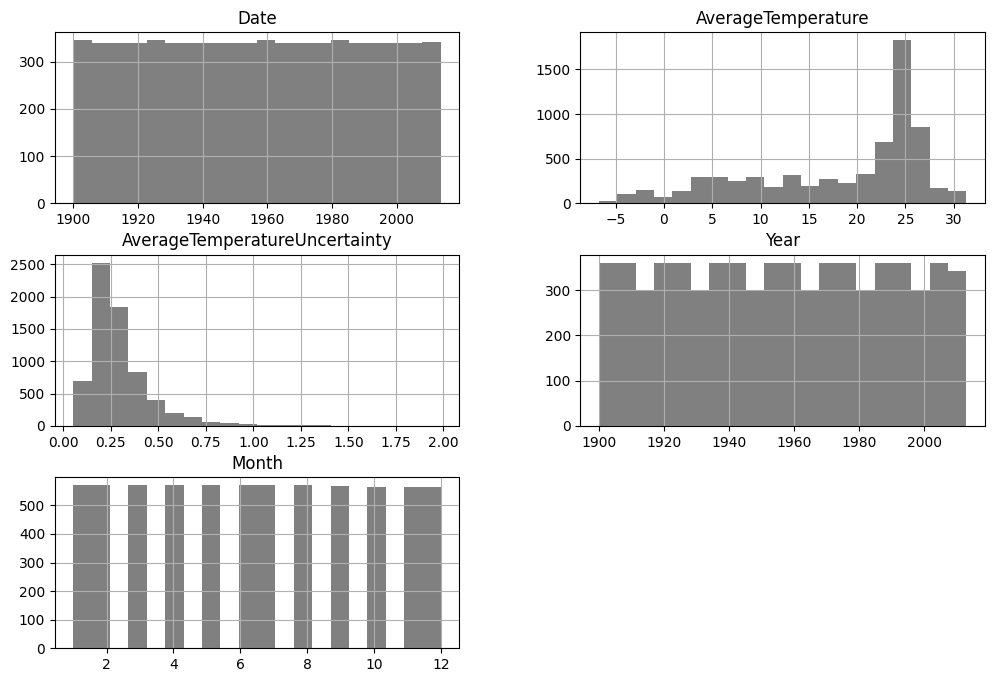

In [ ]:

#Histogram of the dataset
glt_hist = df_data.hist(bins = 20, figsize =(12, 8), color = "grey")



This Histogram above is showing the frequency distribution of this dataset using 20 as the bins.

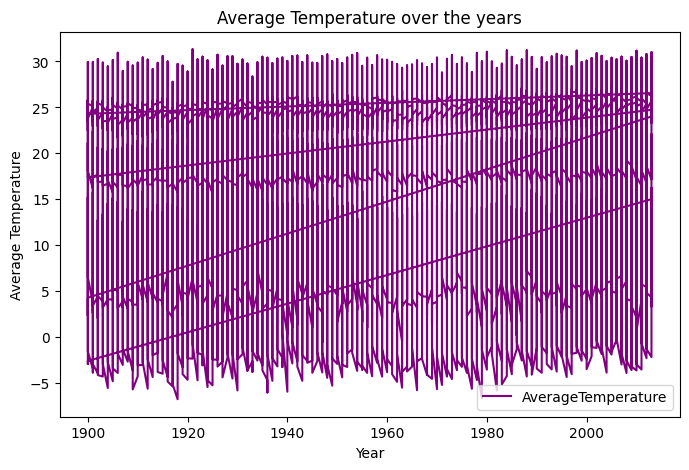

In [ ]:
#Plotting for the average temperature across the years to determine the climate trends.
df_data.plot( x = "Year", y="AverageTemperature", kind = "line", color = "purple")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.title("Average Temperature over the years")
plt.show()

From the line graph above, notice there are seasonal variations caused by temperature change in each year across different years. The fluctuation happened periodically.

<Axes: xlabel='Country'>

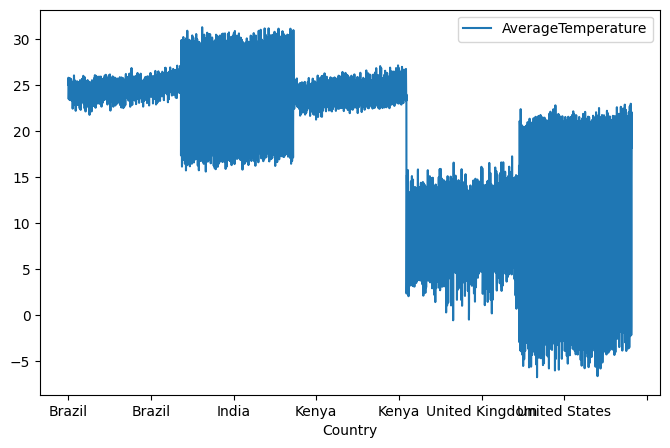

In [ ]:
# plotting to compare the average temperature over various countries showing the spread of the temperature variance.
df_data.plot(x ="Country", y= "AverageTemperature", kind= "line")

Brazil and Kenya have almost similarity in their temperature change which is mostly within 24 degree and 25 degree celsius. India spread is between 15 degree and as high as 30 degree celsius which shows that India is the hottest compared to the other countries. United Kingdom can be cold and warm but not very warm because the spread is between 0 and 15 degree celsius while United States happens to be the coldest among other countries and also becomes warmer than United Kingdom(about -6 degree to 22 degree celsius).

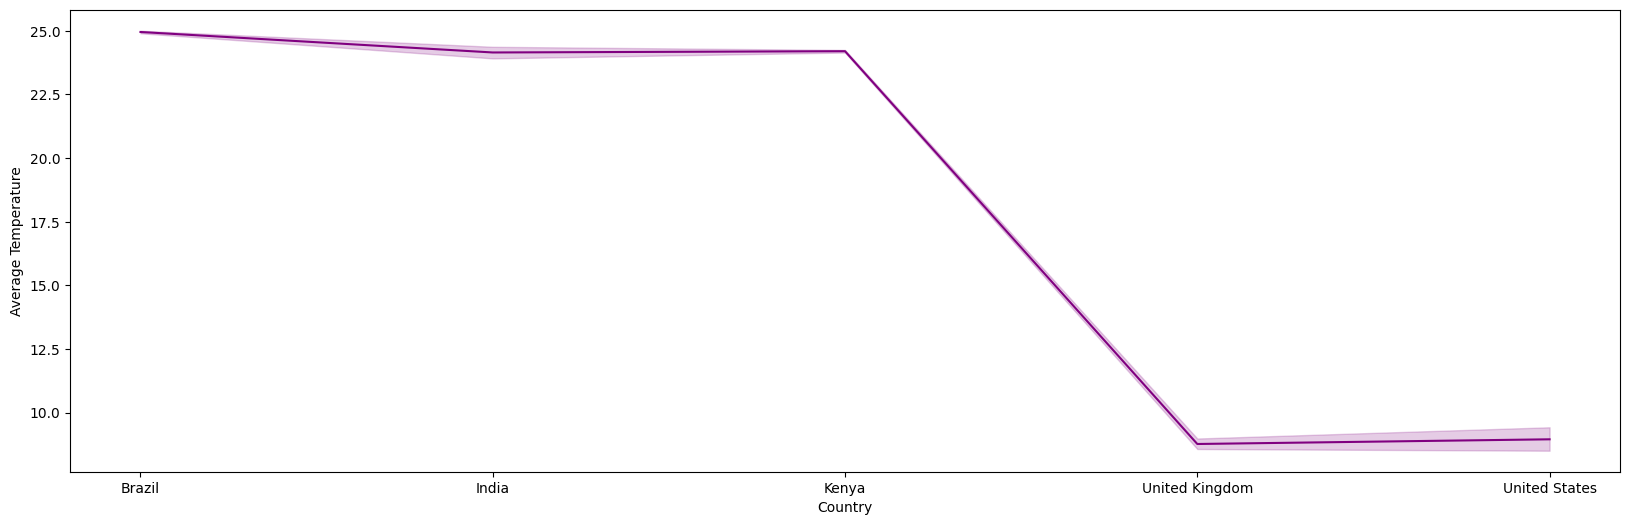

In [ ]:
# plotting the graph to compare the average temperature over various countries showing the Highest and lowest countries by temperature.
plt.figure(figsize =(20, 6))
sns.lineplot(x = "Country", y= "AverageTemperature", data = df_data, color ="purple")
plt.xlabel("Country")
plt.ylabel("Average Temperature")
plt.show()

Here, In Average temperature across the countries, Brazil recorded the highest average temperature compared to other countries with 25.0 degrees, followed by Kenya and India with about 24.198889 and 24.149046 degrees respectively having the United Kingdom and the United States the lowest in average temperature. This deduce that United Kingdom and United states are extremely cold compared to the other countries.

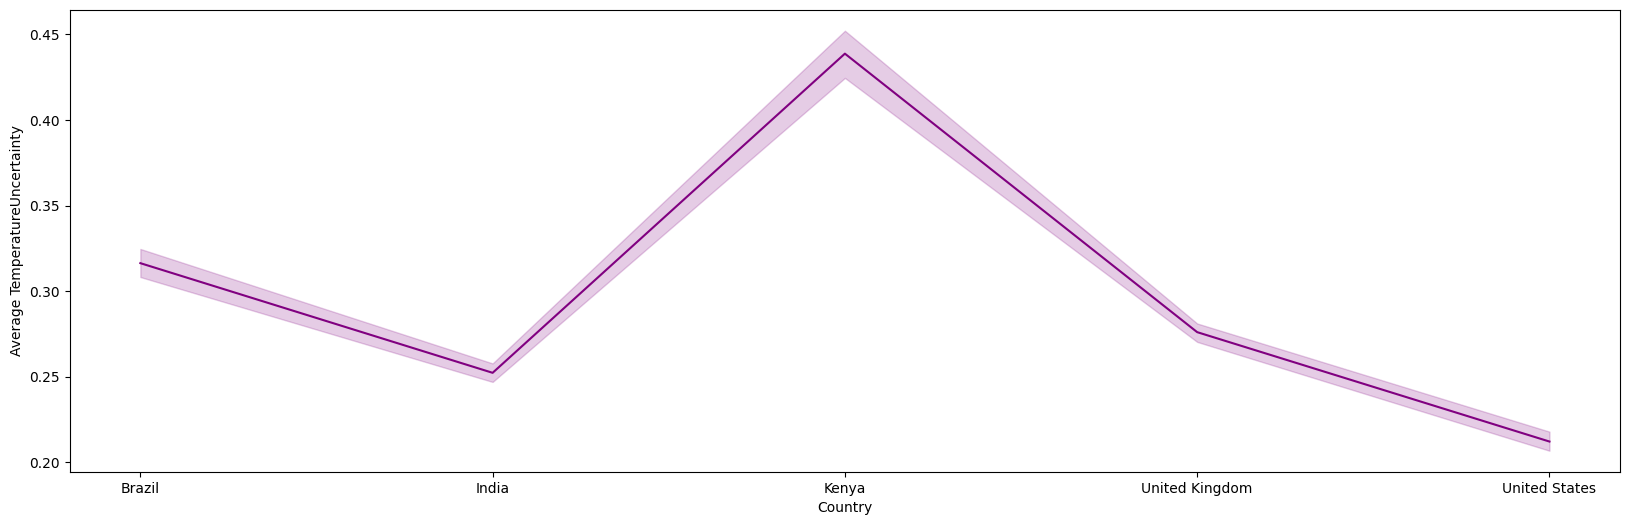

In [ ]:
# plotting to compare the average temperature uncertainty over various countries.
plt.figure(figsize =(20, 6))
sns.lineplot(x = "Country", y= "AverageTemperatureUncertainty", data = df_data, color ="purple")
plt.xlabel("Country")
plt.ylabel("Average TemperatureUncertainty")
plt.show()

In the graph above, Kenya experienced higher uncertainty in the average temperature measurement compared to other countries having United States the lowest in Average Temperature uncertainty.

<ipython-input-30-cbb97dca8846>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data, bins=20, color='purple', kde = 10, hist_kws={"linewidth": 10,'alpha':1})


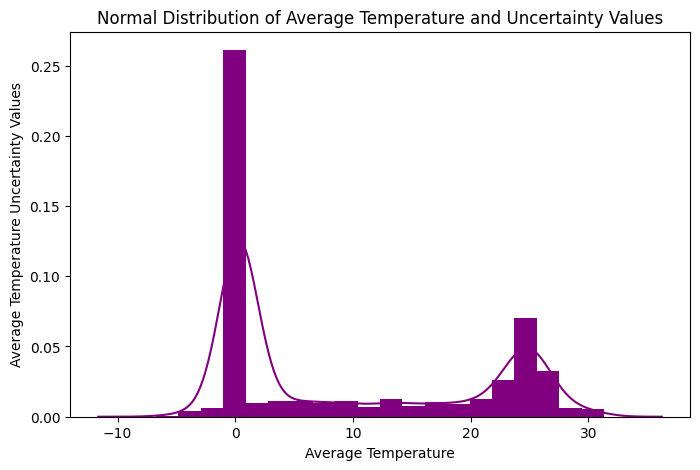

In [ ]:
# Observing the distribution of Average temperature and Average temperature Uncertainty.
data = df_data[["AverageTemperatureUncertainty", "AverageTemperature"]]
ax = sns.distplot(data, bins=20, color='purple', kde = 10, hist_kws={"linewidth": 10,'alpha':1})
ax.set(xlabel='Average Temperature', ylabel='Average Temperature Uncertainty Values', title= "Normal Distribution of Average Temperature and Uncertainty Values")

plt.show()

The normal distribution of the Average Temperature Uncertainty is clustered around zero while Average Temperature values are clustered between 20 and 30 degree celsius.

In [ ]:
#Getting the Statistics Description of Average Temperature
glt_mean = df_data['AverageTemperature'].mean()
print("Mean:", glt_mean)
glt_median = df_data["AverageTemperature"].median()
print("Median:", glt_median)
glt_std = df_data["AverageTemperature"].std()
print("Standard Deviation:", glt_std)

Mean: 18.203824805746958
Median: 22.964
Standard Deviation: 9.010765885031361


In [ ]:
##Getting the Statistics Description of Average Temperature Uncertainty
glt_mean_TU = df_data['AverageTemperatureUncertainty'].mean()
print("Uncertainty Mean:", glt_mean_TU)
glt_median_TU = df_data["AverageTemperatureUncertainty"].median()
print("Uncertianty Median:", glt_median_TU)
glt_std_TU = df_data["AverageTemperatureUncertainty"].std()
print("Uncertainty Standard Deviation:", glt_std_TU)

Uncertainty Mean: 0.299092508429849
Uncertianty Median: 0.255
Uncertainty Standard Deviation: 0.17680210312571115


Text(0.5, 1.0, 'Average Temperature Distribution')

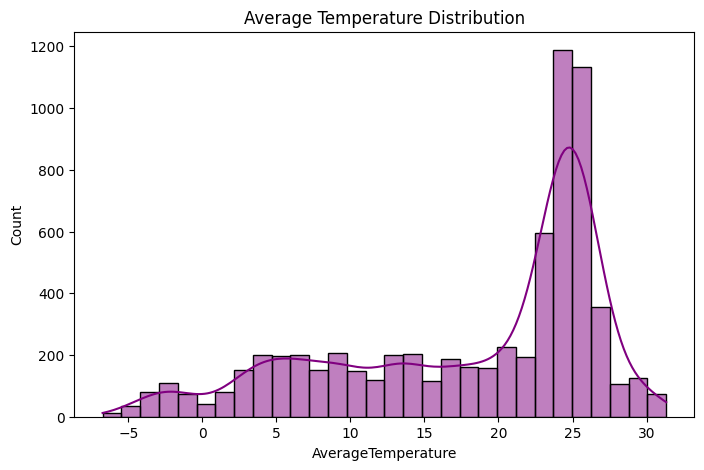

In [ ]:
#Histogram showing the distribution of Average Temperature
ax = sns.histplot(df_data["AverageTemperature"], bins=30, kde = 10, color='purple')
plt.title("Average Temperature Distribution")

The central tendency of the average temperature is peaked within 25 degree celsius. There is a wider spread of the data ranging from -5 to 30 degree celsius which indicates more variability in temperature.However, The Average Temeperature is negatively skewed and the Mean is  18.20, Median is 22.96 while the mode which is the highest occurrence is at 25 degree celsius.

Text(0.5, 1.0, 'Average Temperature Uncertainty Distribution')

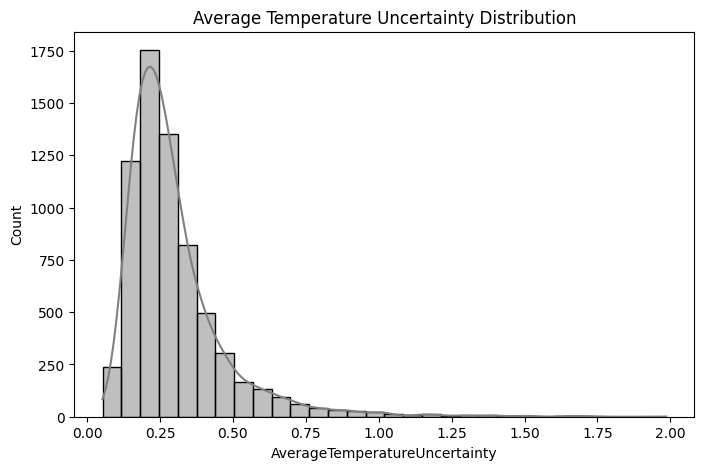

In [ ]:
#Histogram showing the distribution of Average Temperature Uncertainty
ax = sns.histplot(df_data["AverageTemperatureUncertainty"], bins=30, kde = 10, color='grey')
plt.title("Average Temperature Uncertainty Distribution")

The Average temperature Uncertainty is postively skewed and the central tendency is within 0.25 degree celsius. The Uncertainty Mean is 0.299 and Uncertianty Median: 0.255.

Text(0.5, 1.0, 'Comparison of Average Temperature and Average Temperature Uncertainty')

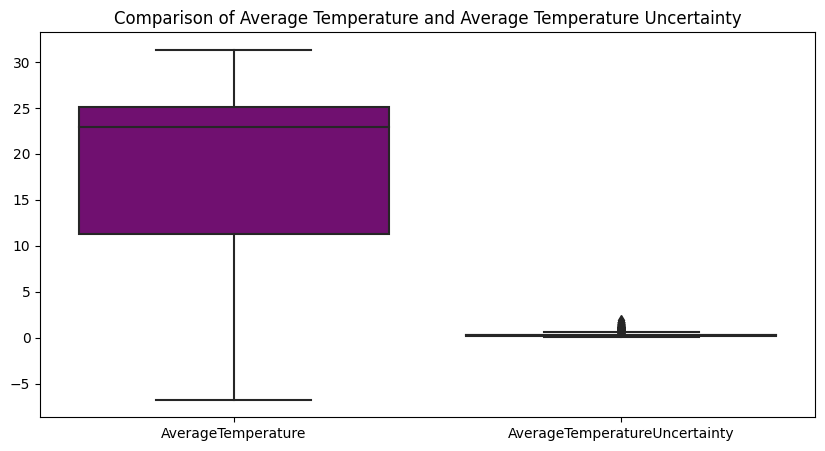

In [ ]:
#Using Boxplot to compare the distribution of Average Temperature and Average Temperature Uncertainty
plt.figure(figsize=(10, 5))
data = df_data[["AverageTemperature", "AverageTemperatureUncertainty"]]
ax= sns.boxplot(data, color = "purple")
plt.title("Comparison of Average Temperature and Average Temperature Uncertainty")

Compare to the Tempperature Uncertainty, the Average Temperature here suggests greater variability in the central 50% of the dataset. This also indicates the difference in the spread of the datasets. There is a shift in the central tendency because the median are distance from each other however, there is a potential outliers seen on average temperature uncertainty.

In [ ]:
#Checking the Correlation of the analysis
data = df_data[["AverageTemperature", "AverageTemperatureUncertainty"]]
data.corr()


AverageTemperature  \
AverageTemperature                       1.000000   
AverageTemperatureUncertainty            0.177636   

                               AverageTemperatureUncertainty  
AverageTemperature                                  0.177636  
AverageTemperatureUncertainty                       1.000000

<Axes: >

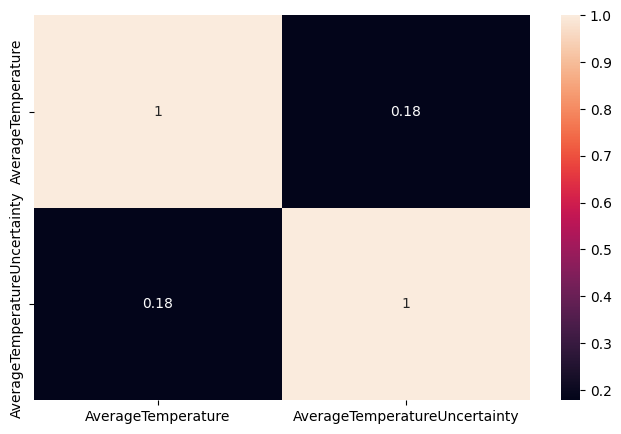

In [ ]:
sns.heatmap(data.corr(), annot = True)

There is no correlation between Average Temperature and Average Temeperature Uncertainty

Text(0.5, 1.0, 'Outliers Detection for Average Temperature in Different countries')

<Figure size 700x500 with 0 Axes>

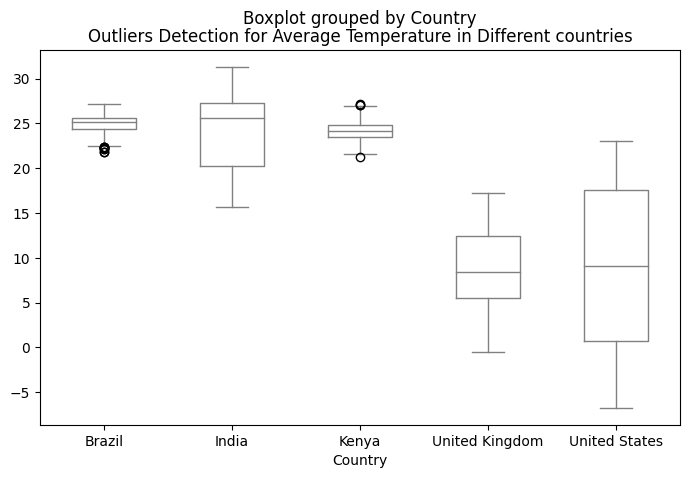

In [ ]:
# Boxplot identifying the outliers in Average temperature
#data1 = df_data[["Country", "AverageTemperature"]]
plt.figure(figsize=(7, 5))
ax = df_data.boxplot(by= "Country", column= "AverageTemperature", color = "grey", grid = False)
plt.title("Outliers Detection for Average Temperature in Different countries")

The outliers seen on the Brazil and Kenya can be described as the true outliers because they represent natural variation in the climate change.

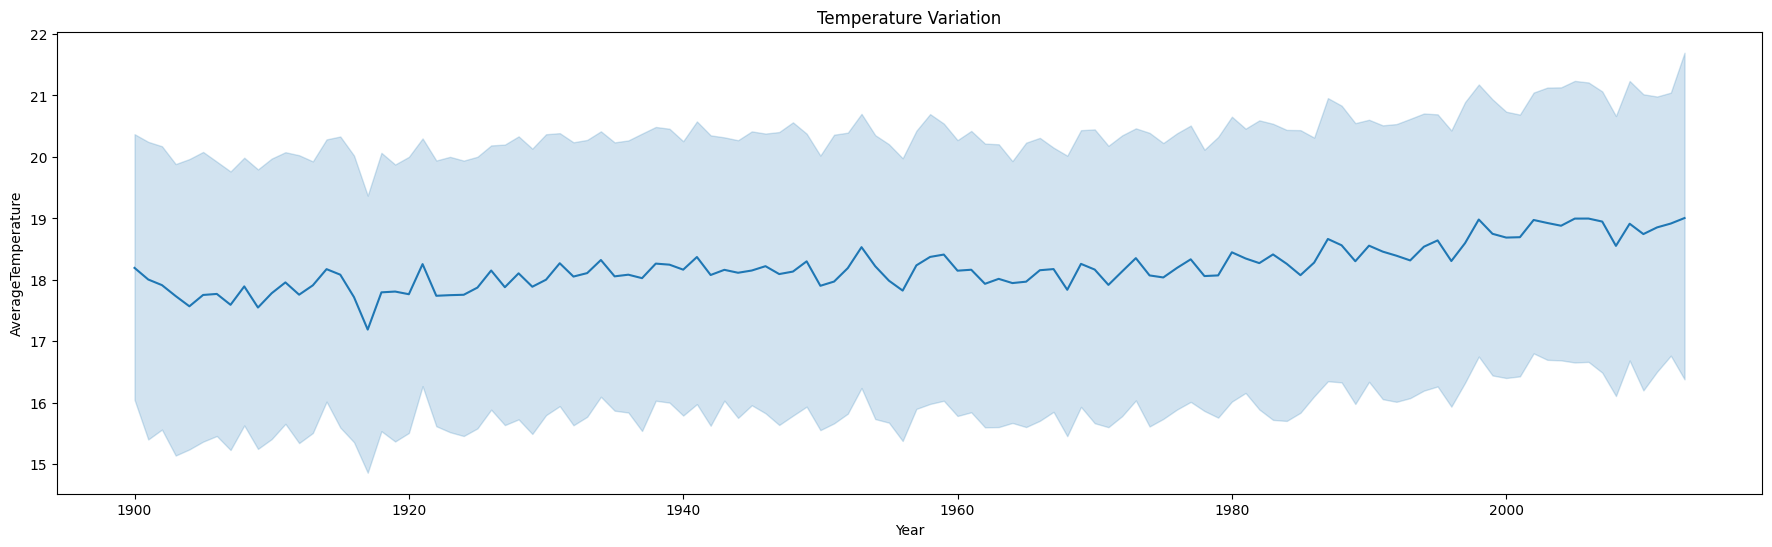

In [ ]:
#Yearly temperature variation
plt.figure(figsize=(22,6))
sns.lineplot(x=df_data.Year, y=df_data['AverageTemperature'])
plt.title('Temperature Variation')
plt.show()

There is significant variation in Temeperature change over the years recorded. Which shows that as the year progresses there is a bit shift in temperature change.


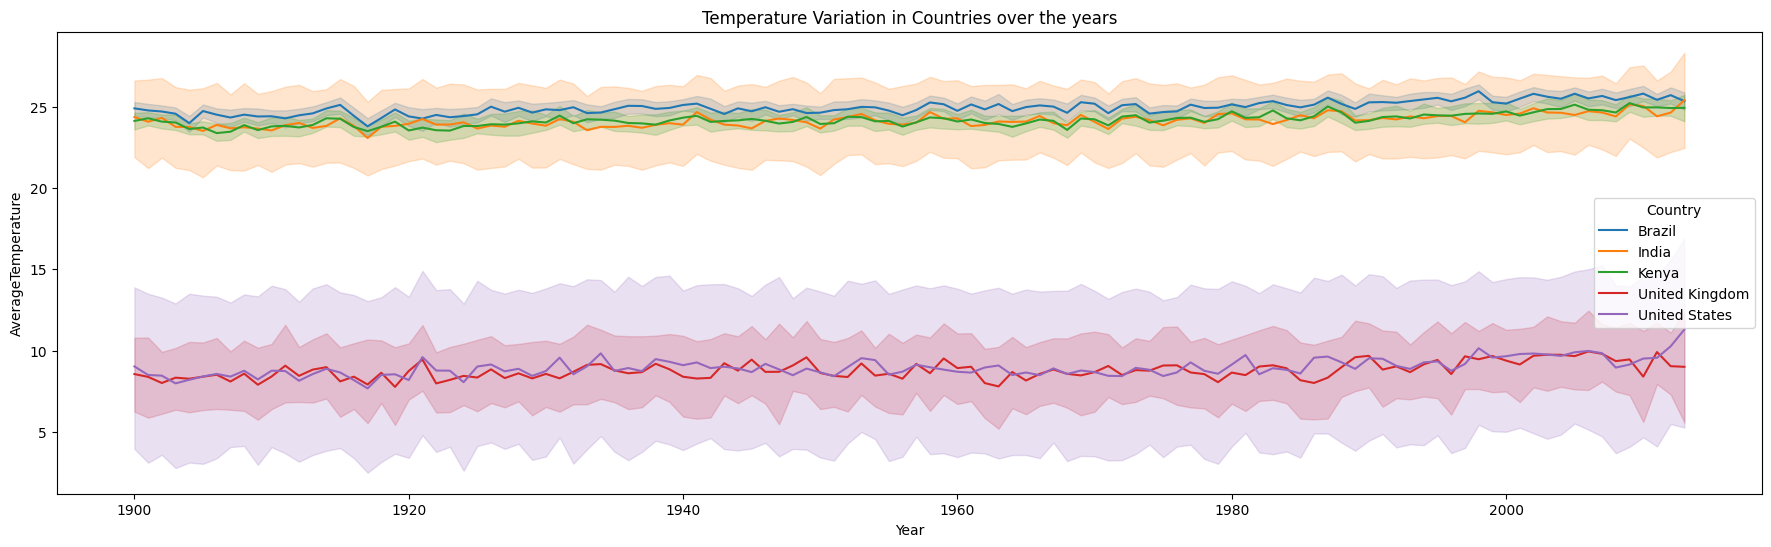

In [ ]:
#Temperature Variation by Country over the years
plt.figure(figsize=(22,6))
sns.lineplot(x="Year",y='AverageTemperature',hue='Country',data=df_data)
plt.title('Temperature Variation in Countries over the years')
plt.show()

Brazil, India, and Kenya have a warmer weather since the average temperature shows they have higher temperature more than United Kingdom and United States with about 24.14 degree <= 25 degree. While United Kingdom and United States feels colder with an average temperature of 8.77 degree <= 8.96.

However, from the analysis, it depicts that there is no significant temperature change in these countries.


# TIME SERIES ANALYSIS

Visualizing the Trend of the Time Series

In [ ]:
#Setting the year as index and creating a data frame for year and temperature
df_data = df_data.set_index(df_data["Date"])
data_trend = pd.DataFrame(df_data["AverageTemperature"])
data_trend




AverageTemperature
Date                          
1900-01-01              25.086
1900-02-01              25.259
1900-03-01              25.835
1900-04-01              24.602
1900-05-01              24.393
...                        ...
2013-05-01              14.073
2013-06-01              20.198
2013-07-01              22.074
2013-08-01              21.168
2013-09-01              18.273

[6821 rows x 1 columns]

Text(0.5, 1.0, 'Trend of the Time Series')

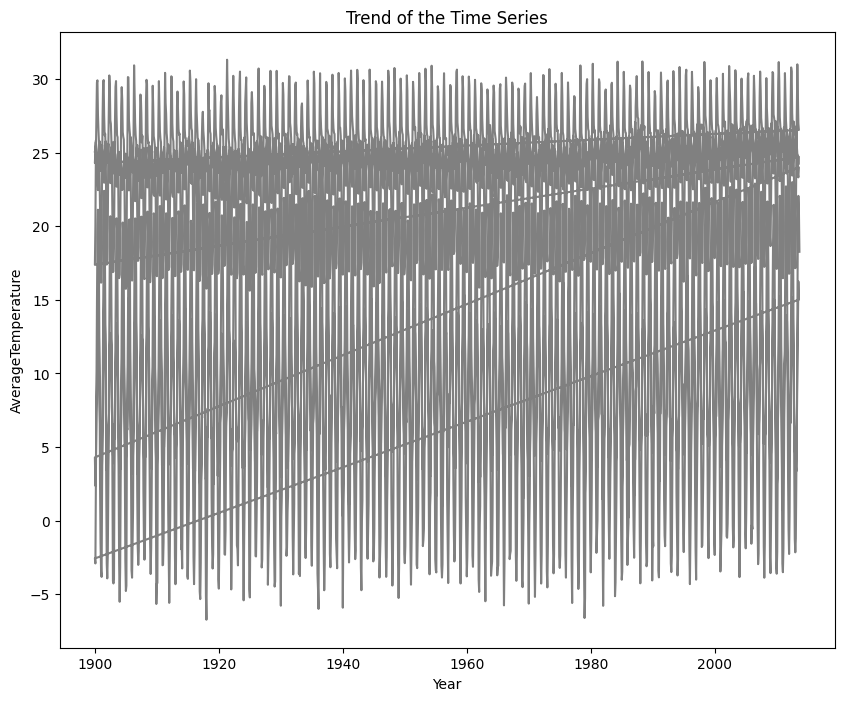

In [ ]:
#Plotting time series trend on the average temperature and year
plt.figure(figsize=(10,8))
plt.plot(data_trend, color = "grey")
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Trend of the Time Series")


In the above graph, the **Trend** is increasing and decreasing in each year.
**Variance**: There is a fluctuation in temperature values over the years which has shown the variation in the time series.  

In [ ]:
#Extracting United Kingdom from country column to see the trend in change in average temperature
df_uk = df_data[df_data["Country"] == "United Kingdom"]
df_uk = pd.DataFrame(df_uk["AverageTemperature"])
df_us = df_data[df_data["Country"]== "United States"]
df_us = pd.DataFrame(df_us["AverageTemperature"])
df_br = df_data[df_data["Country"]== "Brazil"]
df_br = pd.DataFrame(df_br["AverageTemperature"])
df_ky = df_data[df_data["Country"]== "Kenya"]
df_ky = pd.DataFrame(df_ky["AverageTemperature"])
df_id = df_data[df_data["Country"]== "India"]
df_id = pd.DataFrame(df_id["AverageTemperature"])

Text(0.5, 1.0, 'Trend of the Time Series for United Kingdom')

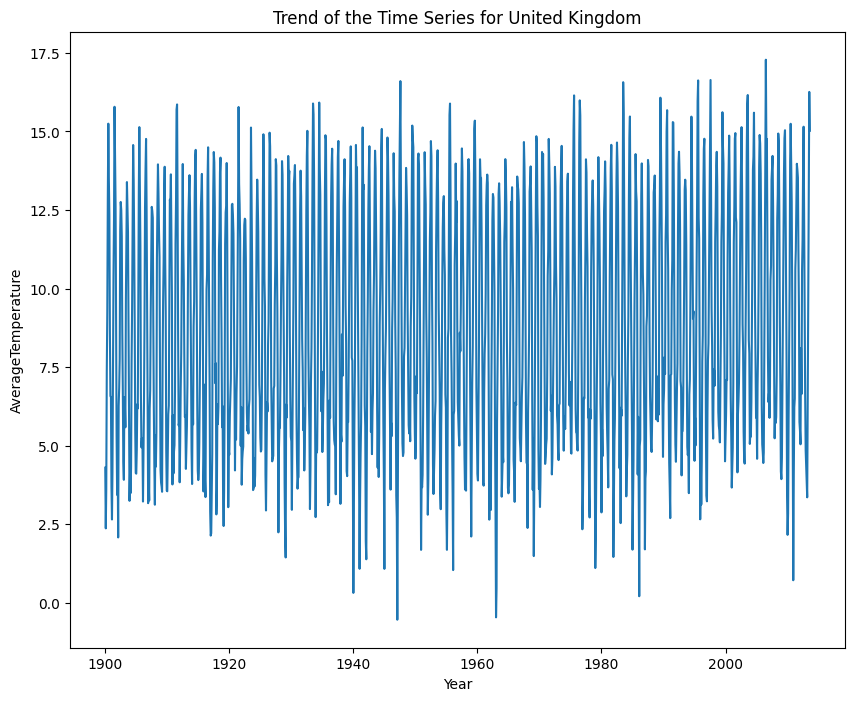

In [ ]:
#Plotting the trend of temperature in United Kingdom over the years
plt.figure(figsize=(10,8))
plt.plot(df_uk)
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Trend of the Time Series for United Kingdom")

In the above graph, the **Trend** in the United Kingdom is increasing and decreasing in each year showing a deep fall in temperature in **1940s** and **1960s** which is **-0.546000**.
**Variance**: There is a fluctuation in temperature values over the years which has shown the variation in the time series.  

Text(0.5, 1.0, 'Trend of the Time Series for United States')

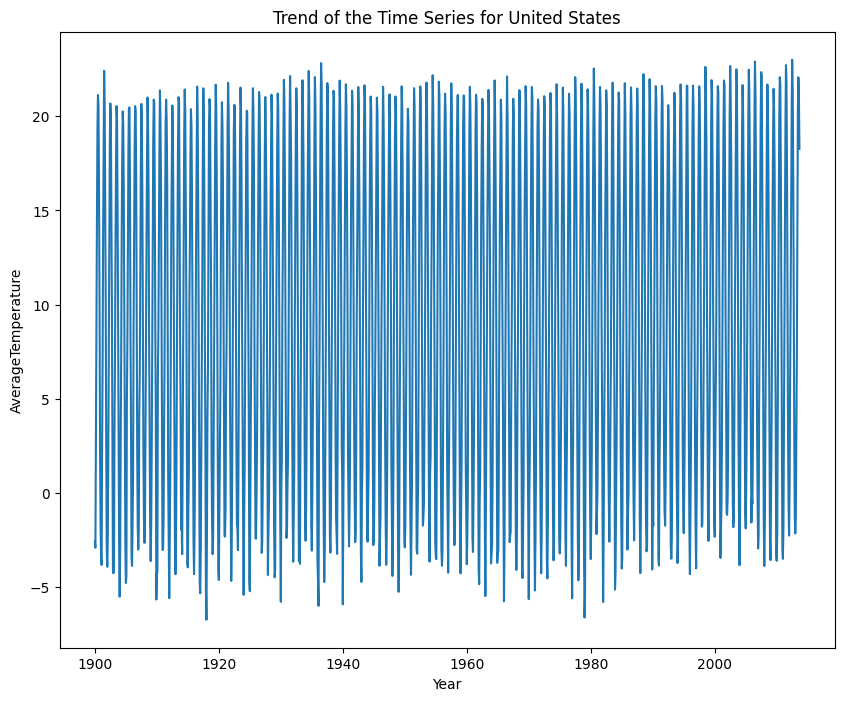

In [ ]:
#Plotting the trend of temperature in United Kingdom over the years
plt.figure(figsize=(10,8))
plt.plot(df_us)
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Trend of the Time Series for United States")

Looking at the graph above, you will notice a wide spread of the temperature variability from negative to over 23 degree celcius. This shows that it can be very cold in the United States and also very warm during a certain season.

Text(0.5, 1.0, 'Trend of the Time Series for Brazil')

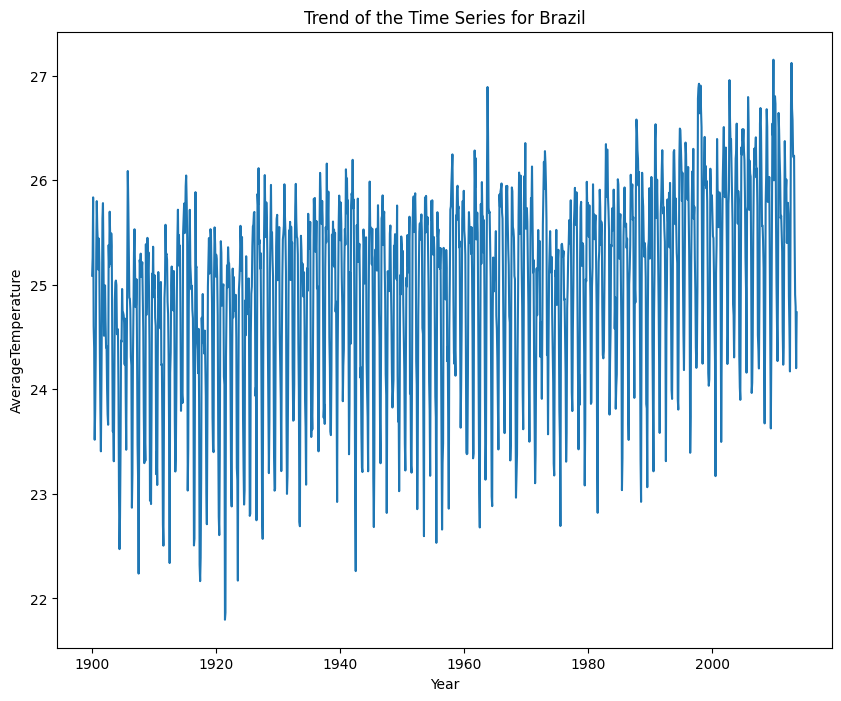

In [ ]:
#Temperature change in Brazil over the years
plt.figure(figsize=(10,8))
plt.plot(df_br)
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Trend of the Time Series for Brazil")

In Brazil, the weather condition there is usually warm with a least temperature of 21.79 degree celcius and gets warmer at 27.15 degree celcius which is the peak. In addtion, the temperture variability moves with the time series as shown on the graph. In terams of years it also shows that as the year progresses there is an increase in temperature. Looking at 1920 and 2000 years, you will notice the temperature rise in 2000 compare to the previous years.

---



Text(0.5, 1.0, 'Trend of the Time Series for Kenya')

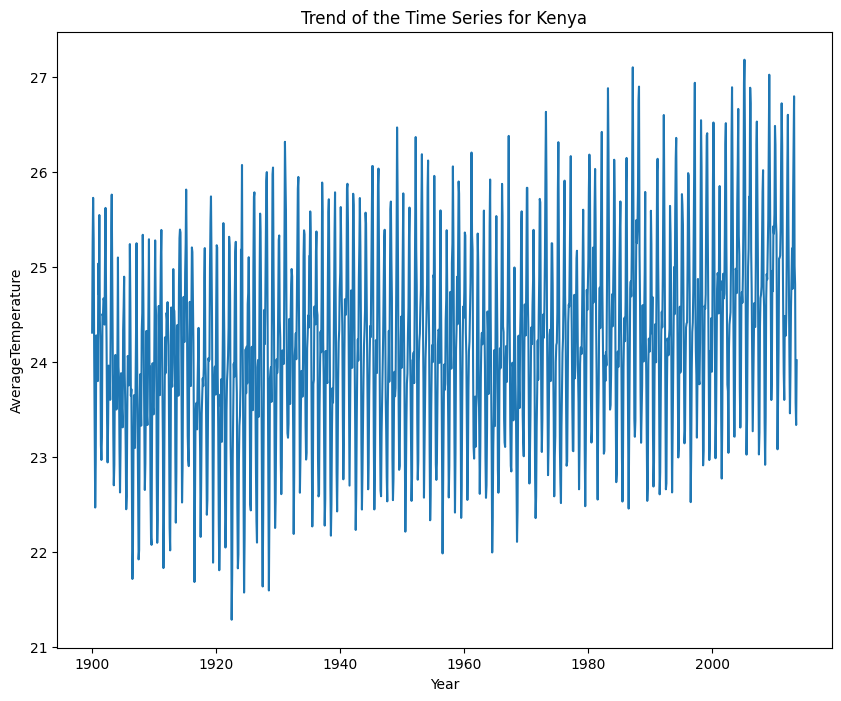

In [ ]:
#Plotting temperature against Kenya
plt.figure(figsize=(10,8))
plt.plot(df_ky)
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Trend of the Time Series for Kenya")

Looking at this Kenya temperature graph, notice that Kenya has almost the same temperature variation as Brazil. There was a temperature dropped down in the year 1920 in both countries and rises significantly in the year 2000.

Text(0.5, 1.0, 'Trend of the Time Series for India')

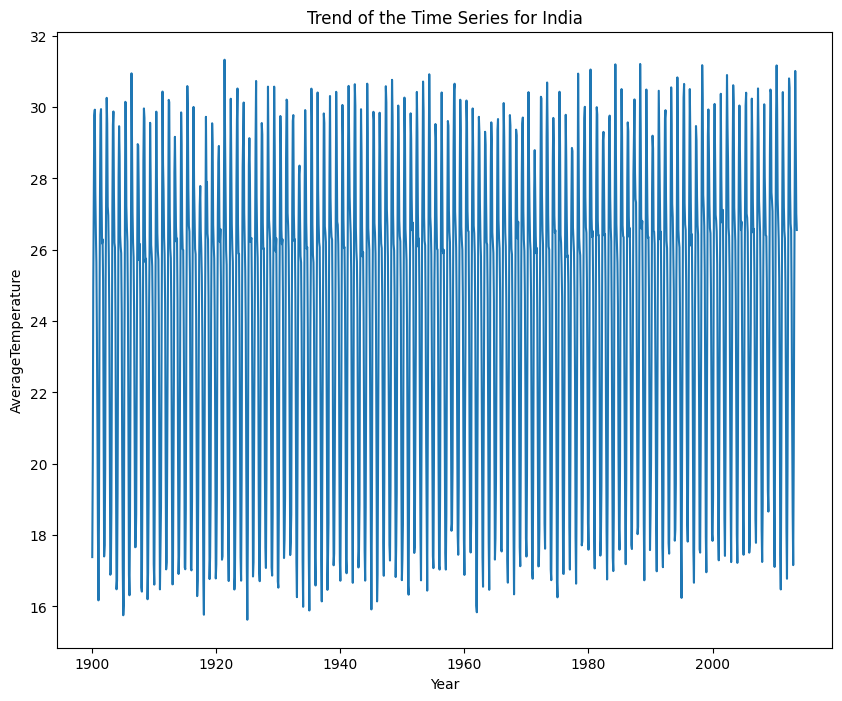

In [ ]:
#Temperature change in India over the years
plt.figure(figsize=(10,8))
plt.plot(df_id)
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Trend of the Time Series for India")

India is the country with the highest temperature amongs the other countries.

<Axes: title={'center': 'Seasonality of the Time Series'}, xlabel='Month', ylabel='AverageTemperature'>

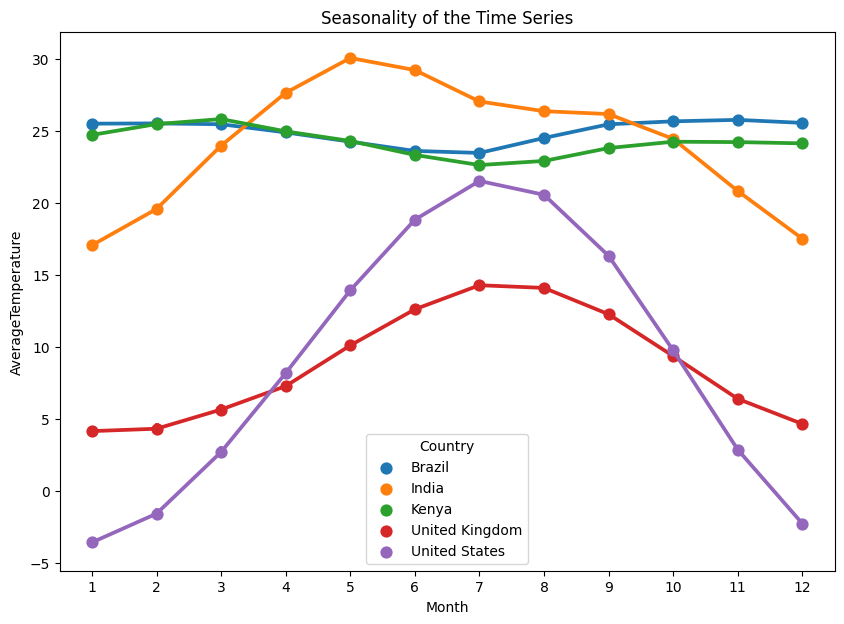

In [ ]:
# Plotting for the seasonality we are going to create a temp dataframe and add columns for Month and Year values
# Stacked line plot
plt.figure(figsize=(10,7))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='AverageTemperature',hue='Country',data=df_data)

From the visualization, On average, there is high temperature rise in month of July over the years for United States and United Kingdom while the temperature in Kenya and Brazil falls down in the same July. India becomes very high in the month of May making the weather very warm. However, in the month of December and January, United States becomes extremely cold which is less than 0 degree celsius, United Kingdom also becomes cold during the same months but not as extreme as United States. India temperature also decreases more in January and December more than Kenya and Brazil. Therefore, January and December should be their coldest weather in the whole year excluding Brazil and Kenya.

# DECOMPOSTION OF TIME SERIES

To provide interpretable pattern for the temperature change, the use of "additive model" will help train the model fast and in development of the model.


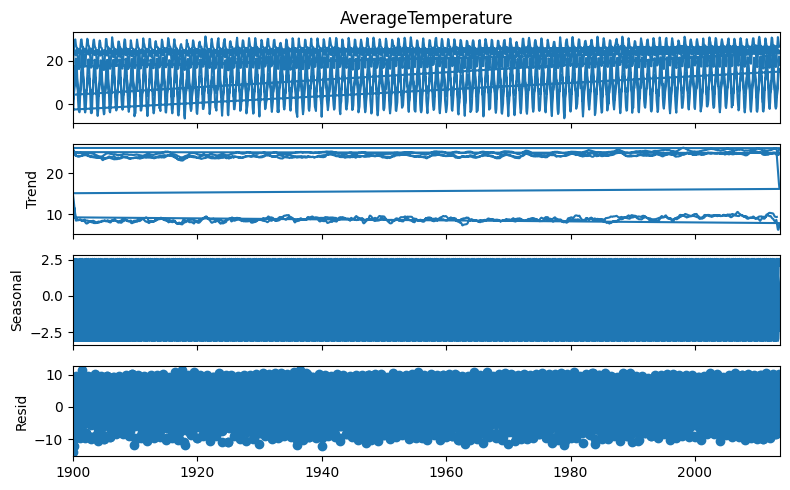

In [ ]:

# Interpolating missing values
#df_data['AverageTemperature'] = df_data['AverageTemperature'].interpolate()



#Interpreble pattern using additive model
add_decomp = sm.tsa.seasonal_decompose(df_data["AverageTemperature"], model = "additive", period = 12)
result = add_decomp.plot()

This graph is showing the trend, seasonality and variance features for the whole countries.

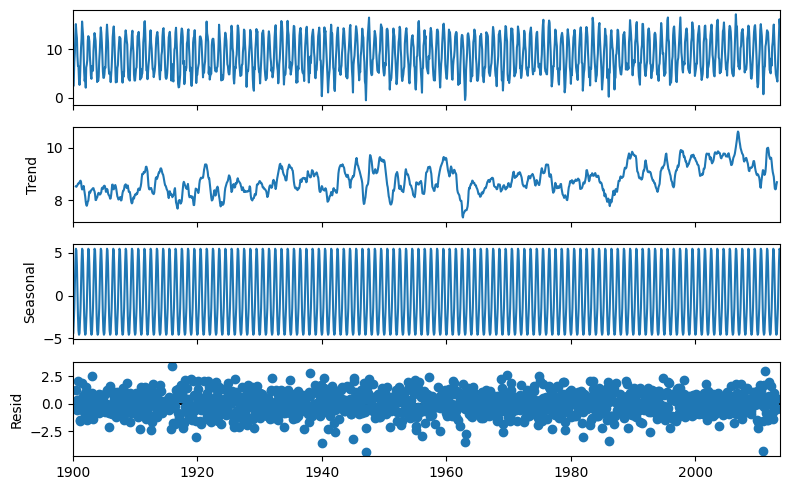

In [ ]:
#Decomposition of Time series for Unite kingdom
adduk_decomp = sm.tsa.seasonal_decompose(df_uk, model = "additive", period = 12)
resultuk = adduk_decomp.plot()

**Trend:** There is a an overall long term pattern in the United Kingdom which captures the increase and decrease in this time series.

**Seasonality:** Over the captured years there is a yearly seasonal pattern which occurs at intervals in the United kingdom.

**Residual:** This represents some errors or noise in the data.

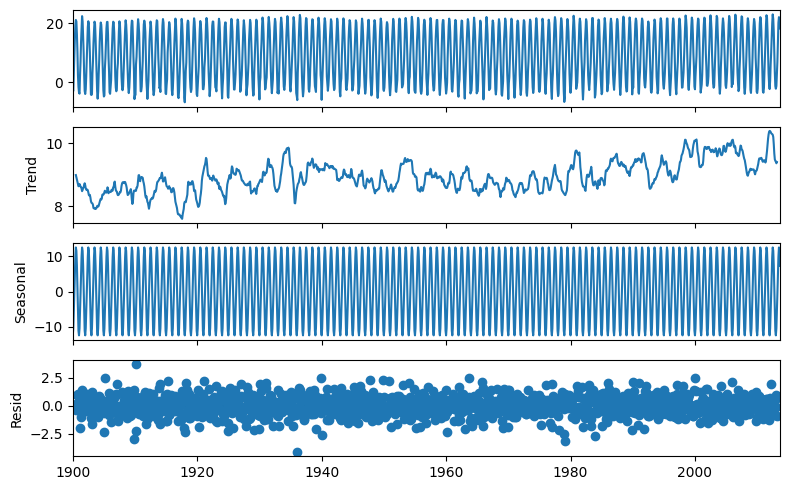

In [ ]:
#Decomposition of Time series for United States
addus_decomp = sm.tsa.seasonal_decompose(df_us, model = "additive", period = 12)
resultus = addus_decomp.plot()

**Trend:** There is an overall long term pattern in the United States which captures the variation in this time series.

**Seasonality:** Over the captured years there is a yearly seasonal pattern which occurs at intervals in the United states.

**Residual:** This represents some errors or noise in the data.

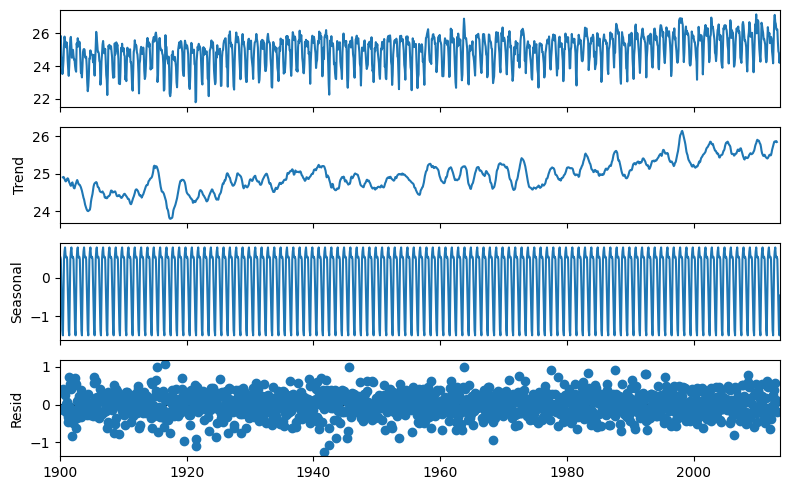

In [ ]:
#Decomposition of Time series for Brazil
addbr_decomp = sm.tsa.seasonal_decompose(df_br, model = "additive", period = 12)
resultbr = addbr_decomp.plot()

**Trend:**  A trend in Brazil which captures the increase and decrease in this time series and fluctuates as the year progresses.

**Seasonality:** Over the captured years there is a yearly seasonal pattern which occurs at intervals in the Brazil.

**Residual:** This represents some errors or noise in the data.

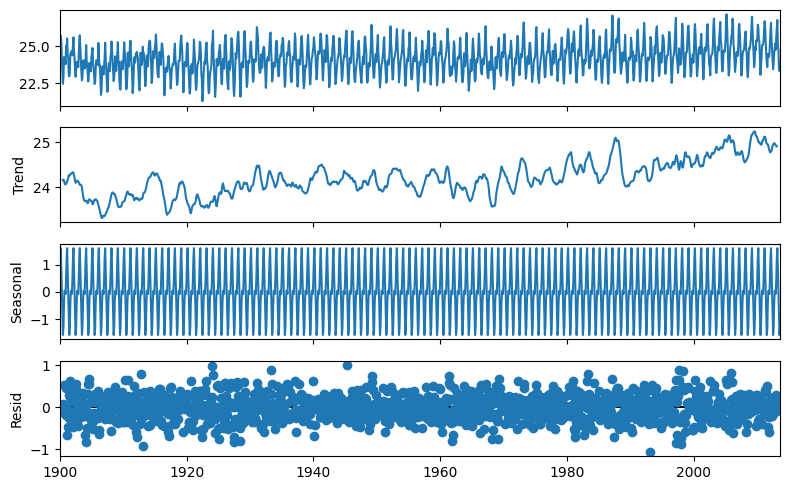

In [ ]:
#Decomposition of Time series for Kenya
addky_decomp = sm.tsa.seasonal_decompose(df_ky, model = "additive", period = 12)
resultky = addky_decomp.plot()

**Trend:** In the Kenya the increase and decrease in this time series have increase with variation.

**Seasonality:** Over the captured years there is a yearly seasonal pattern which occurs at intervals in the United kingdom.

**Residual:** This represents some errors or noise in the data.

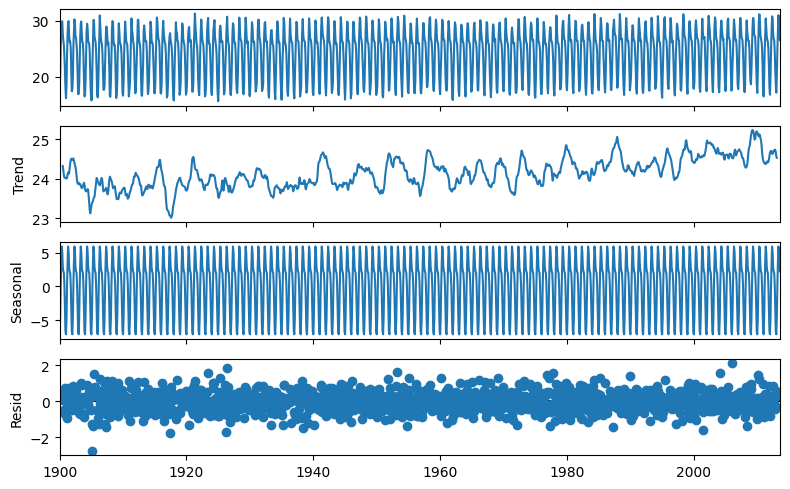

In [ ]:
#Decomposition of Time series for India
addid_decomp = sm.tsa.seasonal_decompose(df_id, model = "additive", period = 12)
resultid = addid_decomp.plot()

**Trend:** the tren in India which captures the increase and decrease in temperature with a bit variation.

**Seasonality:** Over the captured years there is a yearly seasonal pattern which occurs at intervals in the India.

**Residual:** This represents some errors or noise in the data.

 ### CHECKING FOR STATIONARITY


In [ ]:
#Checking the stationarity of the time series using DickeyFuller test.
print("Output of Dickey_Fuller test")
data_test = adfuller(data_trend)
data_output = pd.Series(data_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in data_test[4].items():
  data_output["Critical Value (%s)" %key] = value
  print(data_output)


Output of Dickey_Fuller test
Test Statistics                 -0.923160
P-value                          0.780250
Lags Used                       35.000000
Number of Observation Used    6785.000000
Critical Value (1%)             -3.431314
dtype: float64
Test Statistics                 -0.923160
P-value                          0.780250
Lags Used                       35.000000
Number of Observation Used    6785.000000
Critical Value (1%)             -3.431314
Critical Value (5%)             -2.861966
dtype: float64
Test Statistics                 -0.923160
P-value                          0.780250
Lags Used                       35.000000
Number of Observation Used    6785.000000
Critical Value (1%)             -3.431314
Critical Value (5%)             -2.861966
Critical Value (10%)            -2.566997
dtype: float64


Test Statistic:

The test statistic is less than the critical values at 1%,5%,10% significance levels. This is to say that there is no enough evidence towards the null hypothesis of non-stationarity. Again the P-Value is high therefore no enough evidence to reject the null hypothesis.

As we can see on the above output, the test statistics is less negative than the critical value therefore there's no enough evidence to reject the null hypothesis. This is indicating non-stationarity of the time series.

Since Stationarity is crucial for my analysis, i will use differencing to make my time series Stationary.

### CONVERTING Non-stationarity to Stationarity using DIFFERENCING.

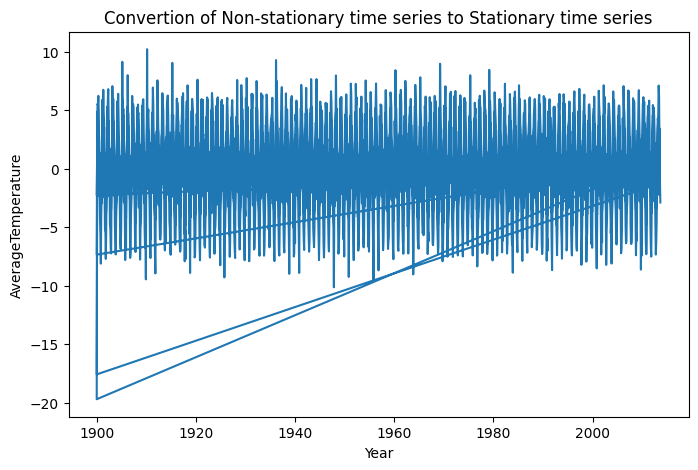

In [ ]:
data_diff = data_trend.diff(periods = 1)                   #First order differencing for all the countries
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Convertion of Non-stationary time series to Stationary time series")
plt.plot(data_diff)

In [ ]:
#Checking if there is a null value introduced while differencing
data_diff.isnull().sum()

AverageTemperature    1
dtype: int64

In [ ]:
#Re-Checking the stationarity of the time series using DickeyFuller test to observe if there is any change using the differencing method.

data_diff.dropna(inplace = True)     # Transformation of data added null values so i drop it.
print("Output of Dickey_Fuller test")
data_test = adfuller(data_diff)
data_output = pd.Series(data_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in data_test[4].items():
  data_output["Critical Value (%s)" %key] = value
  print(data_output)


Output of Dickey_Fuller test
Test Statistics              -1.548278e+01
P-value                       2.543473e-28
Lags Used                     3.500000e+01
Number of Observation Used    6.784000e+03
Critical Value (1%)          -3.431314e+00
dtype: float64
Test Statistics              -1.548278e+01
P-value                       2.543473e-28
Lags Used                     3.500000e+01
Number of Observation Used    6.784000e+03
Critical Value (1%)          -3.431314e+00
Critical Value (5%)          -2.861966e+00
dtype: float64
Test Statistics              -1.548278e+01
P-value                       2.543473e-28
Lags Used                     3.500000e+01
Number of Observation Used    6.784000e+03
Critical Value (1%)          -3.431314e+00
Critical Value (5%)          -2.861966e+00
Critical Value (10%)         -2.566997e+00
dtype: float64


**Test Statistics:** The above output shows that, -1.548278+01 is more negative value, depicting a highly negative trend.

**P-Value:** 2.543473e-28 p-value is very small showing a strong evidence against the null hypothesis, indicating that the time series is stationary.

**Critical Values:** the test statistics is largely negative at all the significance levels, suggesting that in conclusion the null hypothesis can be rejected. Therefore, Null hypothesis  of the non-stationarity of the time series is rejected because there is enough evidence to reject the null hypothesis.

**In conclusion:** We can say the time series is **stationary** because there is very high negative test statistics value and very small P-value. In addition, it can be said that the dataset does not have a unit root and can maintain a stable pattern in future.

### For a Better Visualization, let's examine the Stationary of the time series and apply Differencing where necessary

In [ ]:
#Checking the stationarity of the time series using DickeyFuller test for united kingdom.
print("Output of Dickey_Fuller test")
datauk_test = adfuller(df_uk)
datauk_output = pd.Series(datauk_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in datauk_test[4].items():
  datauk_output["Critical Value (%s)" %key] = value
  print(datauk_output)

Output of Dickey_Fuller test
Test Statistics                 -3.906964
P-value                          0.001984
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
dtype: float64
Test Statistics                 -3.906964
P-value                          0.001984
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
Critical Value (5%)             -2.863701
dtype: float64
Test Statistics                 -3.906964
P-value                          0.001984
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
Critical Value (5%)             -2.863701
Critical Value (10%)            -2.567920
dtype: float64


**Test Statistics** for the United Kingdom is more negative than the critical value. Therefore, it provides evidence against the presence of a unit root.

**The p-value** is below 0.05, which shows enough evidence to reject the null hypothesis and the critical value is also less than the test statistics. In this case, United Kingdom time series is suggesting stationarity.

**In conclusion:** it indicates that differencing may not be necessary, since the time series is stationary.

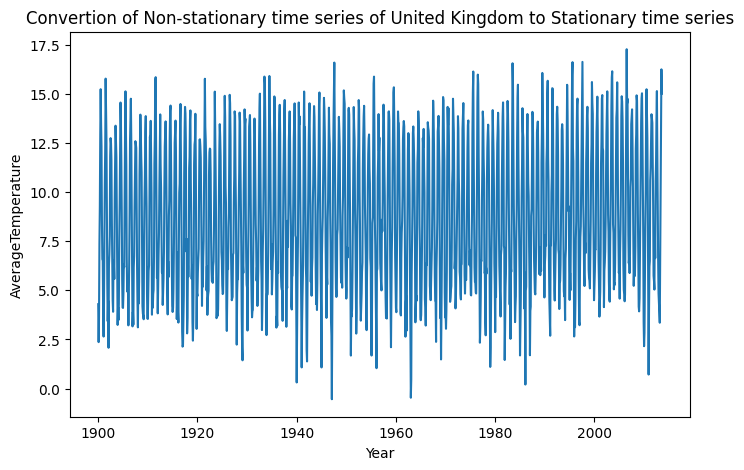

In [ ]:

plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Convertion of Non-stationary time series of United Kingdom to Stationary time series")
plt.plot(df_uk)

In [ ]:
#Checking the stationarity of the time series using DickeyFuller test for united states.
print("Output of Dickey_Fuller test")
dataus_test = adfuller(df_us)
dataus_output = pd.Series(dataus_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in dataus_test[4].items():
  dataus_output["Critical Value (%s)" %key] = value
  print(dataus_output)

Output of Dickey_Fuller test
Test Statistics                 -3.532340
P-value                          0.007194
Lags Used                       24.000000
Number of Observation Used    1340.000000
Critical Value (1%)             -3.435239
dtype: float64
Test Statistics                 -3.532340
P-value                          0.007194
Lags Used                       24.000000
Number of Observation Used    1340.000000
Critical Value (1%)             -3.435239
Critical Value (5%)             -2.863699
dtype: float64
Test Statistics                 -3.532340
P-value                          0.007194
Lags Used                       24.000000
Number of Observation Used    1340.000000
Critical Value (1%)             -3.435239
Critical Value (5%)             -2.863699
Critical Value (10%)            -2.567920
dtype: float64


**Test Statistics** for the United States is more negative(-3.532340) than the critical value. Therefore, it provides evidence against the presence of a unit root.

**The p-value of (0.007194)** is below 0.05, which shows enough evidence to reject the null hypothesis and the critical value is also less than the test statistics. In this case, United Kingdom time series is suggesting stationarity.

**In conclusion:** it indicates that differencing may not be necessary, since the time series is stationary.

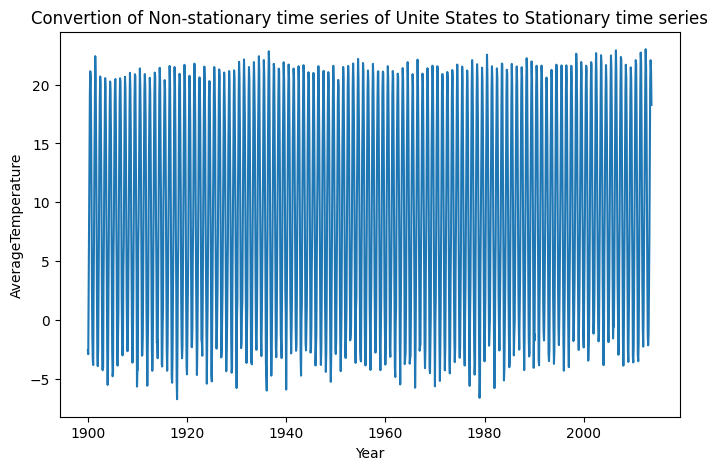

In [ ]:

plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Convertion of Non-stationary time series of Unite States to Stationary time series")
plt.plot(df_us)

In [ ]:
#Checking the stationarity of the time series using DickeyFuller test for Brazil.
print("Output of Dickey_Fuller test")
databr_test = adfuller(df_br)
databr_output = pd.Series(databr_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in databr_test[4].items():
  databr_output["Critical Value (%s)" %key] = value
  print(databr_output)

Output of Dickey_Fuller test
Test Statistics                 -2.404432
P-value                          0.140489
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
dtype: float64
Test Statistics                 -2.404432
P-value                          0.140489
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
Critical Value (5%)             -2.863701
dtype: float64
Test Statistics                 -2.404432
P-value                          0.140489
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
Critical Value (5%)             -2.863701
Critical Value (10%)            -2.567920
dtype: float64



**Test Statistics:** Brazil has a test statistic of (-2.404432) is less negative tahn the critical  value at 10%, it's therefore indicating the non-stationary of the time series in Brazil.

**P-value:** 0.140489 is greater than 0.05 significant level indicating that there isn't enough evidence to reject the null hypothesis of a unit root.

**In conclusion,** based on this test, differencing is needed.

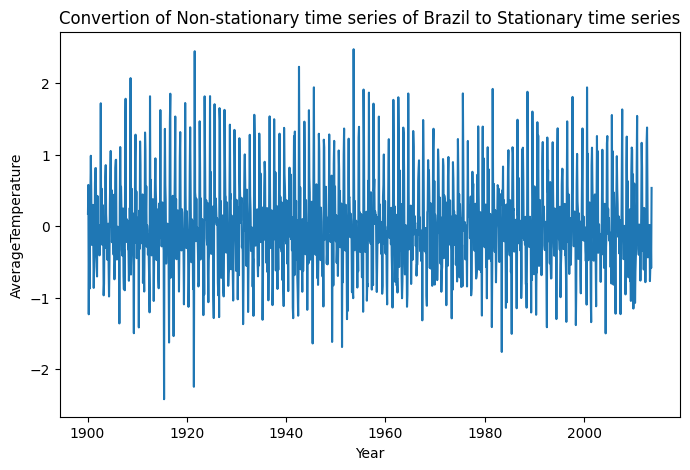

In [ ]:
databr_diff = df_br.diff(periods = 1)                   #First order differencing for Brazil
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Convertion of Non-stationary time series of Brazil to Stationary time series")
plt.plot(databr_diff)

In [ ]:
#Re-Checking the stationarity of the time series using DickeyFuller test to observe if there is any change using the differencing method Brazil.

databr_diff.dropna(inplace = True)     # Transformation of data added null values so i drop it.
print("Output of Dickey_Fuller test")
databr_test = adfuller(databr_diff)
databr_output = pd.Series(databr_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in databr_test[4].items():
  databr_output["Critical Value (%s)" %key] = value
  print(databr_output)

Output of Dickey_Fuller test
Test Statistics              -1.382450e+01
P-value                       7.794546e-26
Lags Used                     2.300000e+01
Number of Observation Used    1.339000e+03
Critical Value (1%)          -3.435243e+00
dtype: float64
Test Statistics              -1.382450e+01
P-value                       7.794546e-26
Lags Used                     2.300000e+01
Number of Observation Used    1.339000e+03
Critical Value (1%)          -3.435243e+00
Critical Value (5%)          -2.863701e+00
dtype: float64
Test Statistics              -1.382450e+01
P-value                       7.794546e-26
Lags Used                     2.300000e+01
Number of Observation Used    1.339000e+03
Critical Value (1%)          -3.435243e+00
Critical Value (5%)          -2.863701e+00
Critical Value (10%)         -2.567920e+00
dtype: float64


**Test Statistics:** -1.382450e+01 is highly negative, showing strong evidence against the presence of the unit root. Stationarity is expected.

**P-value:** 7.794546e-26 is extremely low which is below the common significance level of 0.05. This provides strong evidence against the null hypothesis and supports the stationarity of the differenced time series which i have applied.

**Critical Values:** The test statistic is much more negative than these critical values at the 3 different levels, In that case the null hypothesis is rejected.

**In conclusion:** Differencing has made the time series stationary.

In [ ]:
#Checking the stationarity of the time series using DickeyFuller test for Kenya.
print("Output of Dickey_Fuller test")
dataky_test = adfuller(df_ky)
dataky_output = pd.Series(dataky_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in dataky_test[4].items():
  dataky_output["Critical Value (%s)" %key] = value
  print(dataky_output)

Output of Dickey_Fuller test
Test Statistics                 -2.769726
P-value                          0.062730
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
dtype: float64
Test Statistics                 -2.769726
P-value                          0.062730
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
Critical Value (5%)             -2.863701
dtype: float64
Test Statistics                 -2.769726
P-value                          0.062730
Lags Used                       24.000000
Number of Observation Used    1339.000000
Critical Value (1%)             -3.435243
Critical Value (5%)             -2.863701
Critical Value (10%)            -2.567920
dtype: float64


**Test Statistics:** -2.769726 is more negative at 10% critical value indicateing evidence against the presence of a unit root, which is favorable for stationarity.

**P-value:** 0.062730 is greater than the common significance level of 0.05. Therefore, there is not enough evidence to reject the null hypothesis of a unit root even thou is very close to the 0.05 sigificant value.

**In conclusion:** Diffrencing method should be applied to conevert the non-stationarity to staionarity of the KKenya time series.

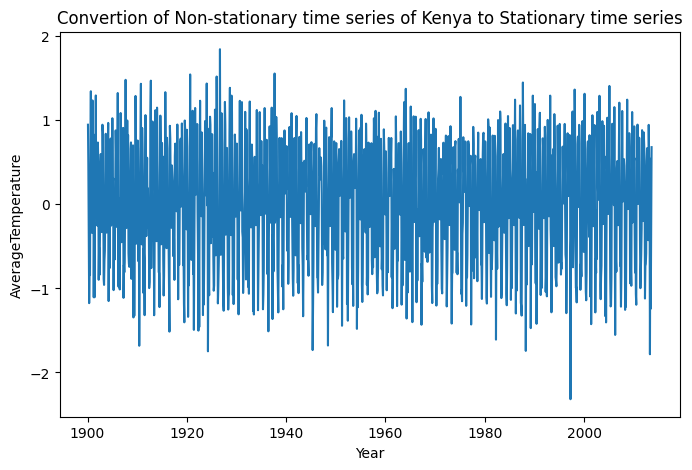

In [ ]:
dataky_diff = df_ky.diff(periods = 1)                   #First order differencing for Kenya
plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Convertion of Non-stationary time series of Kenya to Stationary time series")
plt.plot(dataky_diff)

In [ ]:
#Re-Checking the stationarity of the time series using DickeyFuller test to observe if there is any change using the differencing method for Kenya.

dataky_diff.dropna(inplace = True)     # Transformation of data added null values so i drop it.
print("Output of Dickey_Fuller test")
dataky_test = adfuller(dataky_diff)
dataky_output = pd.Series(dataky_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in dataky_test[4].items():
  dataky_output["Critical Value (%s)" %key] = value
  print(dataky_output)

Output of Dickey_Fuller test
Test Statistics              -1.060751e+01
P-value                       5.950015e-19
Lags Used                     2.400000e+01
Number of Observation Used    1.338000e+03
Critical Value (1%)          -3.435247e+00
dtype: float64
Test Statistics              -1.060751e+01
P-value                       5.950015e-19
Lags Used                     2.400000e+01
Number of Observation Used    1.338000e+03
Critical Value (1%)          -3.435247e+00
Critical Value (5%)          -2.863703e+00
dtype: float64
Test Statistics              -1.060751e+01
P-value                       5.950015e-19
Lags Used                     2.400000e+01
Number of Observation Used    1.338000e+03
Critical Value (1%)          -3.435247e+00
Critical Value (5%)          -2.863703e+00
Critical Value (10%)         -2.567921e+00
dtype: float64


It is stationary now.

In [ ]:
#Checking the stationarity of the time series using DickeyFuller test for India.
print("Output of Dickey_Fuller test")
dataid_test = adfuller(df_id)
dataid_output = pd.Series(dataid_test[0:4],index =["Test Statistics", "P-value", "Lags Used", "Number of Observation Used"])
for key, value in dataid_test[4].items():
  dataid_output["Critical Value (%s)" %key] = value
  print(dataid_output)

Output of Dickey_Fuller test
Test Statistics                 -3.693496
P-value                          0.004206
Lags Used                       23.000000
Number of Observation Used    1340.000000
Critical Value (1%)             -3.435239
dtype: float64
Test Statistics                 -3.693496
P-value                          0.004206
Lags Used                       23.000000
Number of Observation Used    1340.000000
Critical Value (1%)             -3.435239
Critical Value (5%)             -2.863699
dtype: float64
Test Statistics                 -3.693496
P-value                          0.004206
Lags Used                       23.000000
Number of Observation Used    1340.000000
Critical Value (1%)             -3.435239
Critical Value (5%)             -2.863699
Critical Value (10%)            -2.567920
dtype: float64


**Test statistic** is more negative than the critical values.

**P-value** of 0.004206 is less than 0.05 and null hypothesis is rejected.

**In conclusion:** there is enough evidence against the presence of a unit root, suggesting that the time series is stationary, so there is no need to apply differencing.  








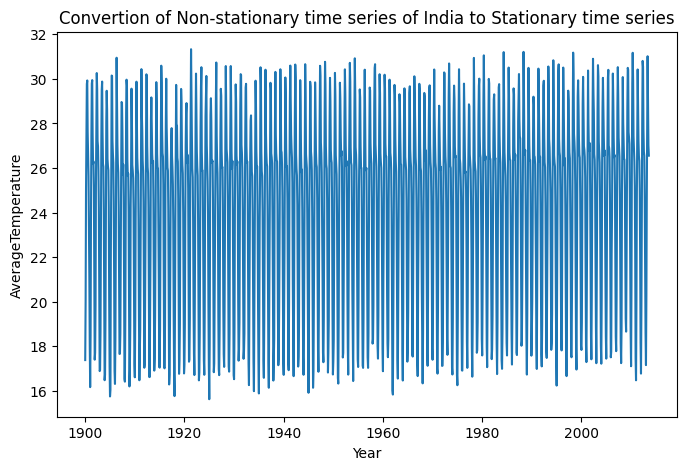

In [ ]:

plt.xlabel("Year")
plt.ylabel("AverageTemperature")
plt.title("Convertion of Non-stationary time series of India to Stationary time series")
plt.plot(df_id)

# FORECASTING

### Using ARIMA Statistical models to forecast the data.

Using PACF function to figure out the order of AR model(p), p = the lag value where the PACF chart crosses the upper confidence interval for the first time.

Using ACF function to figure out the order of MA model(q), q = the lag value where the ACF chart crosses the upper confidence interval for the fist time,

In [ ]:
acf_lag = acf(data_diff, nlags = 20)
pacf_lag = pacf(data_diff, nlags=20, method = "ols")
print("ACF_lag", acf_lag)
print("PACF_lag", pacf_lag)

ACF_lag [ 1.          0.68082058  0.34504433 -0.07795905 -0.43591556 -0.65273659
 -0.72200445 -0.64481014 -0.42698645 -0.06883984  0.35610421  0.72267873
  0.86875141  0.71853091  0.34642431 -0.08268355 -0.4277381  -0.64598364
 -0.71505858 -0.63614345 -0.42263114]
PACF_lag [ 1.          0.68093529 -0.22098687 -0.4205105  -0.32599269 -0.25032844
 -0.30766269 -0.3989544  -0.47388522 -0.46762681 -0.39618353 -0.17556819
  0.08043408  0.15284579  0.04743937 -0.04912483  0.0013564   0.04582644
  0.06774255  0.0779998  -0.01606546]


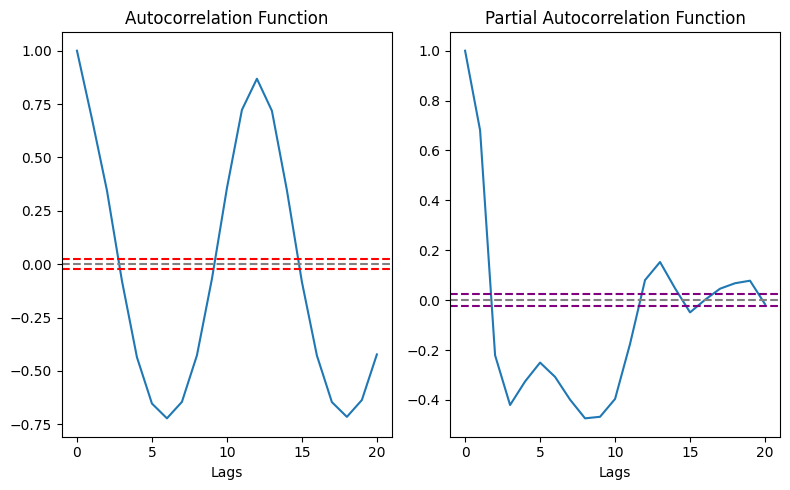

In [ ]:
#Using ACF Function and PACF FUNCTION
#Plot ACF:
plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='grey')

# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(data_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(data_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='grey')

# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(data_diff)),linestyle='--',color='purple')
plt.axhline(y=1.96/np.sqrt(len(data_diff)),linestyle='--',color='purple')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Since ACF helps to identify the correlation between a time series and its lagged values and PACF identifies the direct and indirect relationships between the current observation and its past lags.

In [ ]:
#finding the values of p and q based on significant lags in ACF and PACF graphs

# Identifing  p(AR Order) from PACF using for loop
p = 0
for i in range(1, len(pacf_lag)):
    if pacf_lag[i] < 0.95:  # using 95% confidence interval as threshold
        p = i
        break

# Identify q (MA Order) from ACF using for loop
q = 0
for i in range(1, len(acf_lag)):
    if acf_lag[i] < 0.95:  # using 95% confidence interval as threshold
        q = i
        break

print(f"Identified p: {p}, q: {q}")


Identified p: 1, q: 1


## SPLITTING MY DATA IN TRAINING AND TESTING

In [ ]:
print(data_diff.shape)
data_train=data_diff.iloc[:-33]
data_test=data_diff.iloc[-33:]
print(data_train.shape,data_test.shape)
print(data_test.iloc[0],data_test.iloc[-1])

(6820, 1)
(6787, 1) (33, 1)
AverageTemperature   -0.565
Name: 2011-01-01 00:00:00, dtype: float64 AverageTemperature   -2.895
Name: 2013-09-01 00:00:00, dtype: float64


# MODELING WITH ARIMA

Figuring out the best order for ARIMA model using step-wise

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


stepwise_fit = auto_arima(data_diff['AverageTemperature'],
                          trace=True, suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=21764.405, Time=21.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=32907.526, Time=0.68 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28662.204, Time=1.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=29851.956, Time=2.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32905.527, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=27965.336, Time=6.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=24863.382, Time=23.44 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=21760.675, Time=19.51 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=23620.565, Time=9.24 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=22627.517, Time=37.52 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=21768.330, Time=22.98 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=21757.961, Time=24.80 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=27757.229, Time=3.00 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=21176.277, Time=21.53 sec
 ARIMA(1,0,4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6820
Model:               SARIMAX(2, 0, 5)   Log Likelihood              -10381.603
Date:                Sat, 25 Nov 2023   AIC                          20779.206
Time:                        21:39:36   BIC                          20833.827
Sample:                             0   HQIC                         20798.052
                               - 6820                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7311      0.001   2738.596      0.000       1.730       1.732
ar.L2         -0.9985      0.001  -1583.407      0.000      -1.000      -0.997
ma.L1         -1.9505      0.006   -325.850      0.000      -1.962      -1.939
ma.L2          1.0469      0.015     71.939      0.000       1.018       1.075
ma.L3          0.0163      0.017      0.984      0.325      -0.016       0.049
ma.L4          0.1430      0.015      9.332      0.000       0.113       0.173
ma.L5         -0.2132      0.007    -30.093      0.000      -0.227      -0.199
sigma2         1.2279      0.006    204.126      0.000       1.216       1.240
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            164775.61
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Text(0.5, 1.0, 'Model Combination, RSS: 287710.4561')

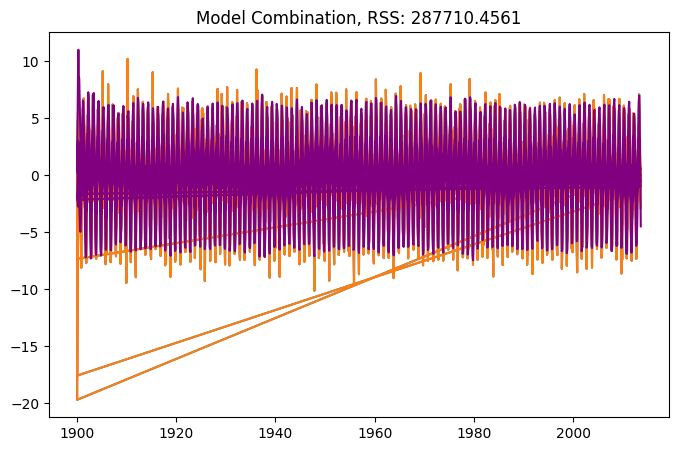

In [ ]:
#Creating ARIMA model for the all the time series
df_model = ARIMA(data_diff, order=(2, 0, 5))

#Fitting the model
fit_ARIMA = df_model.fit()
plt.plot(data_diff)

#Plotting the ARIMA model
plt.plot(data_diff)
plt.plot(fit_ARIMA.fittedvalues[1:], color='purple')
plt.title('Model Combination, RSS: %.4f'% sum((fit_ARIMA.fittedvalues[1:]-data_diff['AverageTemperature'])**2))

###Creating ARIMA model for each country

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Model Combination United Kingdom, RSS: 2214.5625')

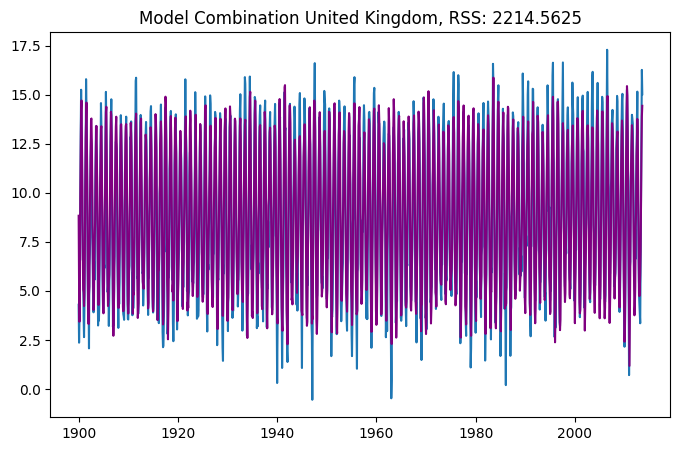

In [ ]:
#ARIMA Model for United Kingdom
dfuk_model = ARIMA(df_uk, order=(2, 0, 5))

# Fitting the model
fituk_ARIMA = dfuk_model.fit()

# Calculating residuals
residuals = df_uk['AverageTemperature'] - fituk_ARIMA.fittedvalues

# Calculating RSS
rss = sum(residuals**2)

# Plotting the ARIMA model
plt.plot(df_uk['AverageTemperature'])
plt.plot(fituk_ARIMA.fittedvalues, color='purple')
plt.title('Model Combination United Kingdom, RSS: %.4f' % rss)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Text(0.5, 1.0, 'Model Combination United States, RSS: 1660.0763')

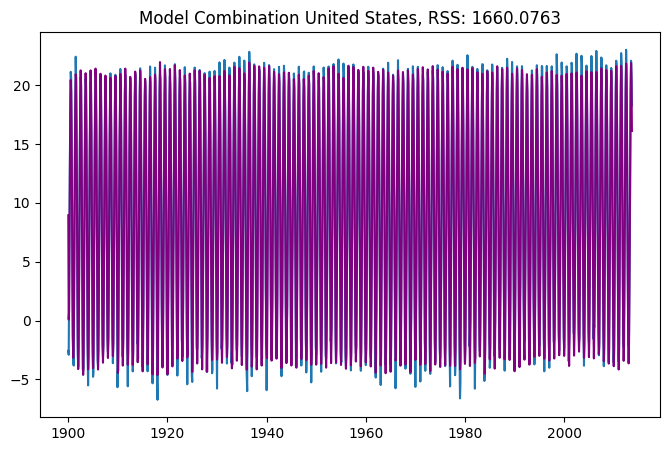

In [ ]:
#ARIMA Model for United States
dfus_model = ARIMA(df_us, order=(2, 0, 5))

# Fit the model
fitus_ARIMA = dfus_model.fit()

# Calculating residuals
residuals = df_us['AverageTemperature'] - fitus_ARIMA.fittedvalues

# Calculating RSS
rss = sum(residuals**2)

# Plotting the ARIMA model
plt.plot(df_us['AverageTemperature'])
plt.plot(fitus_ARIMA.fittedvalues, color='purple')
plt.title('Model Combination United States, RSS: %.4f' % rss)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

Text(0.5, 1.0, 'Model Combination Brazil, RSS: 329.2888')

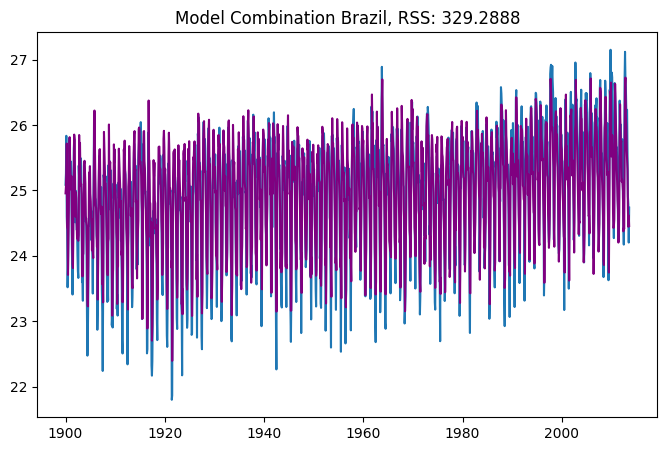

In [ ]:
#ARIMA Model for Brazil
dfbr_model = ARIMA(df_br, order=(2, 0, 5))

# Fitting the model
fitbr_ARIMA = dfbr_model.fit()

# Calculate residuals
residuals = df_br['AverageTemperature'] - fitbr_ARIMA.fittedvalues

# Calculate RSS
rss = sum(residuals**2)

# Plotting the ARIMA model
plt.plot(df_br['AverageTemperature'])
plt.plot(fitbr_ARIMA.fittedvalues, color='purple')
plt.title('Model Combination Brazil, RSS: %.4f' % rss)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

Text(0.5, 1.0, 'Model Combination Kenya, RSS: 325.8537')

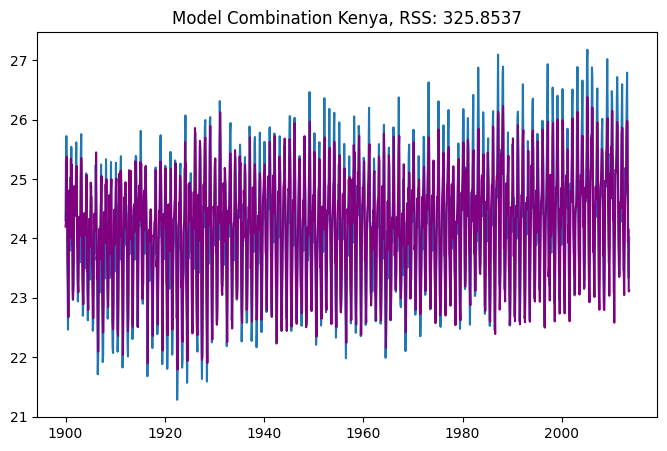

In [ ]:
#ARIMA Model for Kenya
dfky_model = ARIMA(df_ky, order=(2, 0, 5))

# Fitting the model
fitky_ARIMA = dfky_model.fit()

# Calculating residuals
residuals = df_ky['AverageTemperature'] - fitky_ARIMA.fittedvalues

# Calculating RSS
rss = sum(residuals**2)

# Plotting the ARIMA model
plt.plot(df_ky['AverageTemperature'])
plt.plot(fitky_ARIMA.fittedvalues, color='purple')
plt.title('Model Combination Kenya, RSS: %.4f' % rss)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

Text(0.5, 1.0, 'Model Combination India, RSS: 1705.7124')

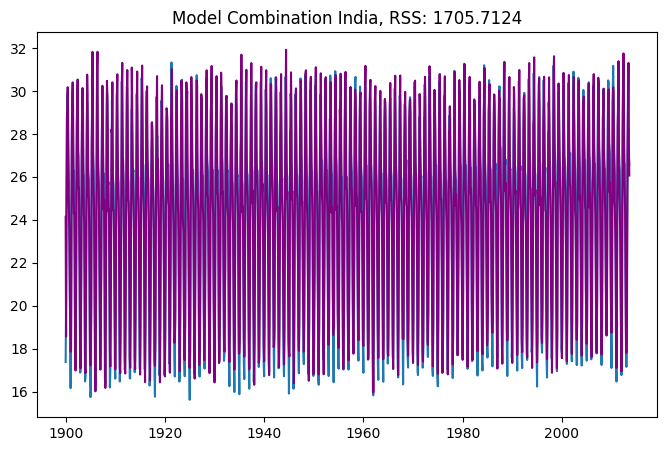

In [ ]:
#ARIMA Model for India
dfid_model = ARIMA(df_id, order=(2, 0, 5))

# Fitting the model
fitid_ARIMA = dfid_model.fit()

# Calculate residuals
residuals = df_id['AverageTemperature'] - fitid_ARIMA.fittedvalues

# Calculate RSS
rss = sum(residuals**2)

# Plotting the ARIMA model
plt.plot(df_id['AverageTemperature'])
plt.plot(fitid_ARIMA.fittedvalues, color='purple')
plt.title('Model Combination India, RSS: %.4f' % rss)


In [ ]:
#Summary of the ARIMA model using summary ()
print(fit_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 6820
Model:                 ARIMA(2, 0, 5)   Log Likelihood              -10381.090
Date:                Sun, 26 Nov 2023   AIC                          20780.180
Time:                        09:07:29   BIC                          20841.629
Sample:                             0   HQIC                         20801.382
                               - 6820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -0.916      0.359      -0.007       0.002
ar.L1          1.7311      0.001   2688.563      0.000       1.730       1.732
ar.L2         -0.9985      0.001  -1543.592      0.0

##PREDICTING THE MODEL USING TEST

<Axes: xlabel='Date'>

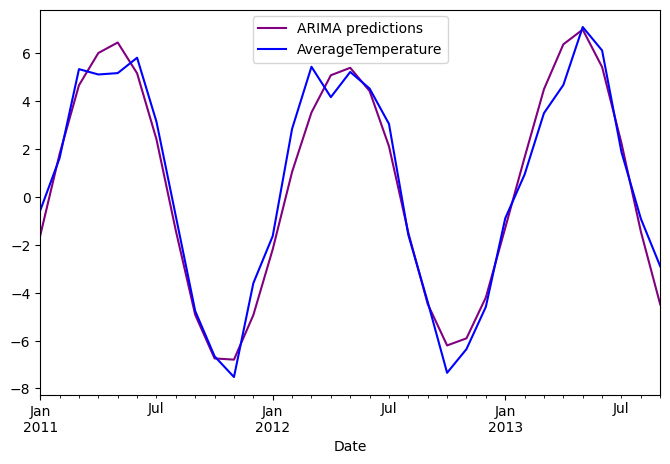

In [ ]:
#Prediction of the model for all the countries
start=len(data_train)
end=len(data_train)+len(data_test)-1

index_future_dates=pd.date_range(start='2011-01-01',end='2013-09-01', freq='MS')
pred_1=fit_ARIMA.predict(start=len(data_train),end=end,typ='levels').rename('ARIMA predictions')
pred_1.index=index_future_dates
pred_1.plot(legend=True, color ="purple")
data_test['AverageTemperature'].plot(legend=True, color = "blue")


(1364, 1)
(1331, 1) (33, 1)
AverageTemperature    0.711
Name: 2010-12-01 00:00:00, dtype: float64 AverageTemperature    15.022
Name: 2013-08-01 00:00:00, dtype: float64


<Axes: xlabel='Date'>

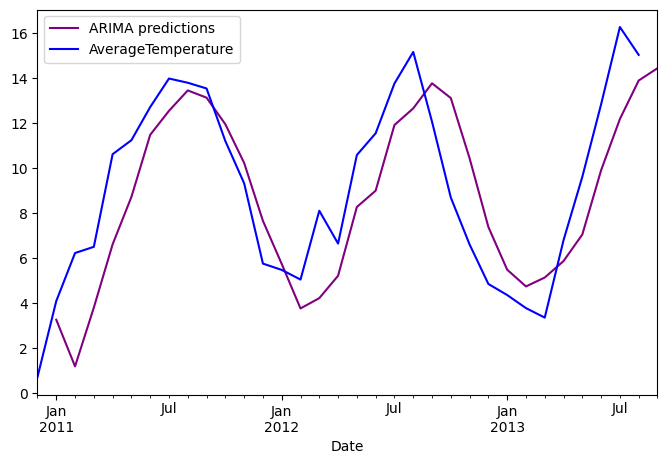

In [ ]:
#Prediction model for United Kingdom
print(df_uk.shape)
datauk_train=df_uk.iloc[:-33]
datauk_test=df_uk.iloc[-33:]
print(datauk_train.shape,datauk_test.shape)
print(datauk_test.iloc[0],datauk_test.iloc[-1])


start=len(datauk_train)
end=len(datauk_train)+len(datauk_test)-1

index_future_ukdates=pd.date_range(start='2011-01-01',end='2013-09-01', freq='MS')
pred_uk=fituk_ARIMA.predict(start=len(datauk_train),end=end,typ='levels').rename('ARIMA predictions')
pred_uk.index=index_future_ukdates
pred_uk.plot(legend=True, color ="purple")
datauk_test['AverageTemperature'].plot(legend=True, color = "blue")

(1365, 1)
(1332, 1) (33, 1)
AverageTemperature   -3.507
Name: 2011-01-01 00:00:00, dtype: float64 AverageTemperature    18.273
Name: 2013-09-01 00:00:00, dtype: float64


<Axes: xlabel='Date'>

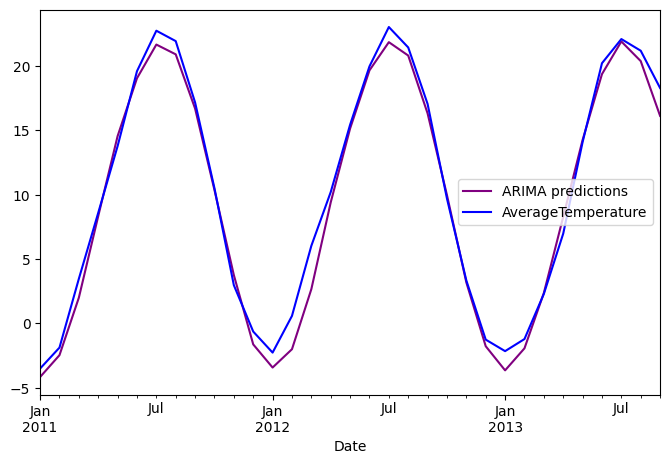

In [ ]:
#Prediction model for United States
print(df_us.shape)
dataus_train=df_us.iloc[:-33]
dataus_test=df_us.iloc[-33:]
print(dataus_train.shape,dataus_test.shape)
print(dataus_test.iloc[0],dataus_test.iloc[-1])


start=len(dataus_train)
end=len(dataus_train)+len(dataus_test)-1

index_future_usdates=pd.date_range(start='2011-01-01',end='2013-09-01', freq='MS')
pred_us=fitus_ARIMA.predict(start=len(dataus_train),end=end,typ='levels').rename('ARIMA predictions')
pred_us.index=index_future_usdates
pred_us.plot(legend=True, color ="purple")
dataus_test['AverageTemperature'].plot(legend=True, color = "blue")


(1364, 1)
(1331, 1) (33, 1)
AverageTemperature    26.038
Name: 2010-12-01 00:00:00, dtype: float64 AverageTemperature    24.736
Name: 2013-08-01 00:00:00, dtype: float64


<Axes: xlabel='Date'>

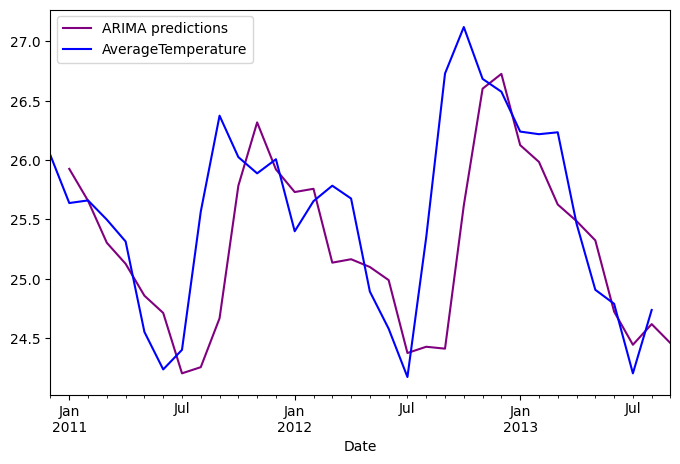

In [ ]:
#Prediction model for Brazil
print(df_br.shape)
databr_train=df_br.iloc[:-33]
databr_test=df_br.iloc[-33:]
print(databr_train.shape,databr_test.shape)
print(databr_test.iloc[0],databr_test.iloc[-1])


start=len(databr_train)
end=len(databr_train)+len(databr_test)-1

index_future_brdates=pd.date_range(start='2011-01-01',end='2013-09-01', freq='MS')
pred_br=fitbr_ARIMA.predict(start=len(databr_train),end=end,typ='levels').rename('ARIMA predictions')
pred_br.index=index_future_brdates
pred_br.plot(legend=True, color ="purple")
databr_test['AverageTemperature'].plot(legend=True, color = "blue")

(1364, 1)
(1331, 1) (33, 1)
AverageTemperature    25.116
Name: 2010-12-01 00:00:00, dtype: float64 AverageTemperature    24.014
Name: 2013-08-01 00:00:00, dtype: float64


<Axes: xlabel='Date'>

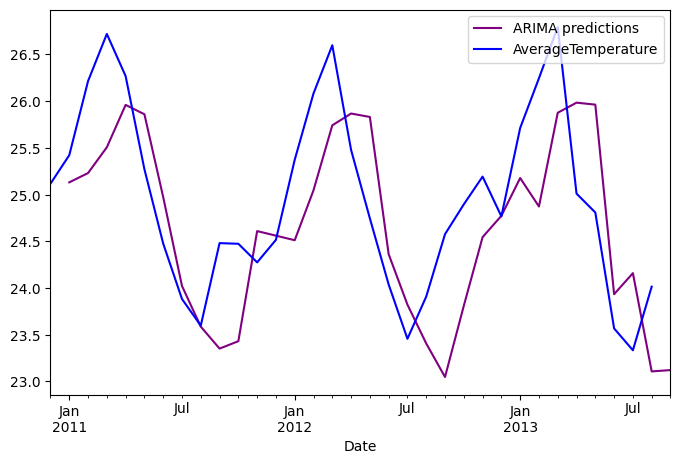

In [ ]:
#Prediction model for Kenya
print(df_ky.shape)
dataky_train=df_ky.iloc[:-33]
dataky_test=df_ky.iloc[-33:]
print(dataky_train.shape,dataky_test.shape)
print(dataky_test.iloc[0],dataky_test.iloc[-1])


start=len(dataky_train)
end=len(dataky_train)+len(dataky_test)-1

index_future_kydates=pd.date_range(start='2011-01-01',end='2013-09-01', freq='MS')
pred_ky=fitky_ARIMA.predict(start=len(dataky_train),end=end,typ='levels').rename('ARIMA predictions')
pred_ky.index=index_future_kydates
pred_ky.plot(legend=True, color ="purple")
dataky_test['AverageTemperature'].plot(legend=True, color = "blue")

(1364, 1)
(1331, 1) (33, 1)
AverageTemperature    17.455
Name: 2010-12-01 00:00:00, dtype: float64 AverageTemperature    26.555
Name: 2013-08-01 00:00:00, dtype: float64


<Axes: xlabel='Date'>

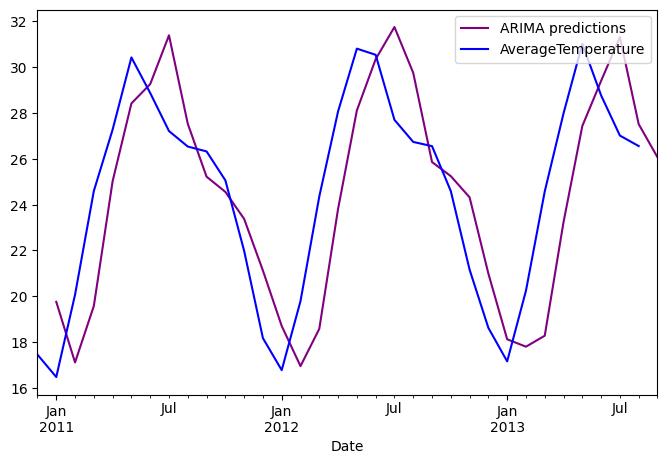

In [ ]:
#Prediction model for India
print(df_id.shape)
dataid_train=df_id.iloc[:-33]
dataid_test=df_id.iloc[-33:]
print(dataid_train.shape,dataid_test.shape)
print(dataid_test.iloc[0],dataid_test.iloc[-1])

start=len(dataid_train)
end=len(dataid_train)+len(dataid_test)-1

index_future_iddates=pd.date_range(start='2011-01-01',end='2013-09-01', freq='MS')
pred_id=fitid_ARIMA.predict(start=len(dataid_train),end=end,typ='levels').rename('ARIMA predictions')
pred_id.index=index_future_iddates
pred_id.plot(legend=True, color ="purple")
dataid_test['AverageTemperature'].plot(legend=True, color = "blue")

In [ ]:
#Checking the number of prediction for our fitted model
predictions_data = pd.Series(fit_ARIMA.fittedvalues, copy=True)

print('Number of predictions: ', len(predictions_data))
print(predictions_data.head())
print(predictions_data.tail())

Number of predictions:  6820
Date
1900-02-01   -0.002141
1900-03-01    0.119696
1900-04-01    0.450026
1900-05-01   -0.928121
1900-06-01   -0.504300
dtype: float64
Date
2013-05-01    6.997197
2013-06-01    5.431337
2013-07-01    2.248053
2013-08-01   -1.443201
2013-09-01   -4.489968
dtype: float64


# FUTURE PREDICTION FOR ALL THE COUNTRIES IN THE NEXT 5 YEARS.

Forecasting for the monthly average temperature
 for the next 5 years which is from 2011 to 2015. The total observation for the predicted data = 6820, therefore 60 months which is 5 years will be added to it. So "end" count = 6880

Using statsmodels to plot_predict() method.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'FUTURE PREDICTION FOR ALL THE COUNTRIES FROM 2011 - 2015')

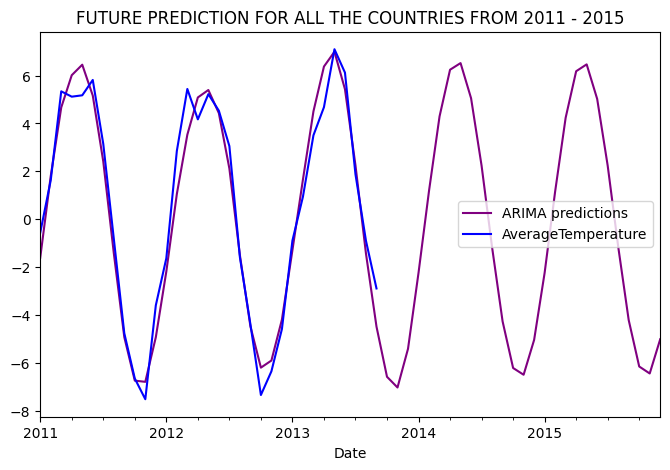

In [ ]:
#FUTURE PREDICTION FOR ALL THE COUNTRIES
start=len(data_train)
end=len(data_train)+len(data_test)-1

index_future_dates=pd.date_range(start='2011-01-01',end='2015-12-01', freq='MS')
pred_future=fit_ARIMA.predict(start=start, end=end+27, typ='levels').rename('ARIMA predictions')
pred_future.index=index_future_dates
pred_future.plot(legend=True, color = "purple")
data_test['AverageTemperature'].plot(legend=True, color = "blue")
plt.title("FUTURE PREDICTION FOR ALL THE COUNTRIES FROM 2011 - 2015")

The future prediction shows a close ARIMA prediction to the actual data. From the graph notice that the change in temperature slighly changed but within the range of the actual data. It can also depicts the continous temeperature variability in the coming years.

<Axes: >

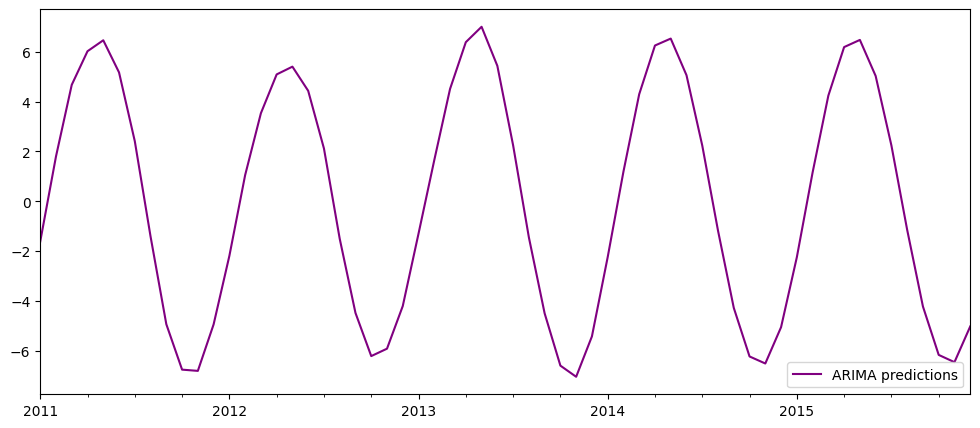

In [ ]:
pred_future.plot(figsize=(12,5),legend=True, color ="purple")



In [ ]:
print(pred_future)

2011-01-01   -1.612750
2011-02-01    1.798818
2011-03-01    4.669579
2011-04-01    6.017247
2011-05-01    6.456017
2011-06-01    5.167751
2011-07-01    2.410549
2011-08-01   -1.411173
2011-09-01   -4.926769
2011-10-01   -6.747258
2011-11-01   -6.797074
2011-12-01   -4.933192
2012-01-01   -2.186126
2012-02-01    1.050182
2012-03-01    3.532108
2012-04-01    5.087332
2012-05-01    5.398650
2012-06-01    4.429778
2012-07-01    2.117853
2012-08-01   -1.499627
2012-09-01   -4.474120
2012-10-01   -6.204097
2012-11-01   -5.907107
2012-12-01   -4.198435
2013-01-01   -1.294459
2013-02-01    1.654255
2013-03-01    4.505574
2013-04-01    6.379594
2013-05-01    6.997197
2013-06-01    5.431337
2013-07-01    2.248053
2013-08-01   -1.443201
2013-09-01   -4.489968
2013-10-01   -6.586728
2013-11-01   -7.033555
2013-12-01   -5.415546
2014-01-01   -2.239711
2014-02-01    1.189308
2014-03-01    4.294624
2014-04-01    6.246187
2014-05-01    6.523746
2014-06-01    5.055529
2014-07-01    2.236785
2014-08-01 

In [ ]:
pred_future.describe()

count    60.000000
mean     -0.027056
std       4.704674
min      -7.033555
25%      -4.599168
50%      -0.046429
75%       4.546575
max       6.997197
Name: ARIMA predictions, dtype: float64

## Summary Result for all the Time Series

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred_1, data_test['AverageTemperature']))
print("Root Mean Square Error for all countries: ", rmse)


mse= (mean_squared_error(pred_1, data_test['AverageTemperature']))
print("Mean Sequared Error for all countries: ", mse)

mean_datadiff = data_diff["AverageTemperature"].mean()
print("The mean of the differenced Timeseries: ", mean_datadiff)

Mean_datatest = data_test["AverageTemperature"].mean()
print("Mean of test data: ", Mean_datatest)


Root Mean Square Error for all countries:  0.8933432231770583
Mean Sequared Error for all countries:  0.7980621143963753
The mean of the differenced Timeseries:  -0.000998973607038125
Mean of test data:  0.6428787878787878


#Future Forecasting for all the countries for 5 Years.

**United Kingdom forecast for 5 years**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'United Kingdom forecast for 5 years')

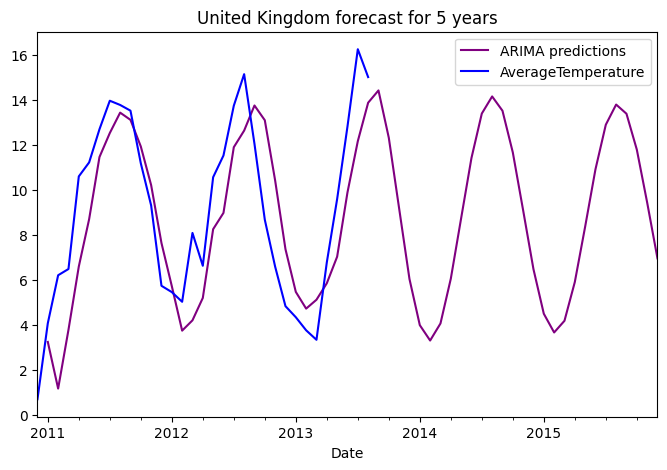

In [ ]:
start=len(datauk_train)
end=len(datauk_train)+len(datauk_test)-1

index_future_ukdates=pd.date_range(start='2011-01-01',end='2015-12-01', freq='MS')
preduk_future=fituk_ARIMA.predict(start=start, end=end+27, typ='levels').rename('ARIMA predictions')
preduk_future.index=index_future_ukdates
preduk_future.plot(legend=True, color = "purple")
datauk_test['AverageTemperature'].plot(legend=True, color = "blue")
plt.title("United Kingdom forecast for 5 years")

United Kingdom can be extremely cold just like the United States but not as much as United states. In United Kingdom the temperature is not as warm as United States, Brazil, Kenya and India when their temperature increases towards the month of July that is the peak of their temperature as shown on the graph. ARIMA prediction has also predicted for the future almost the same temperature variance using the past values and the current values.  

<Axes: >

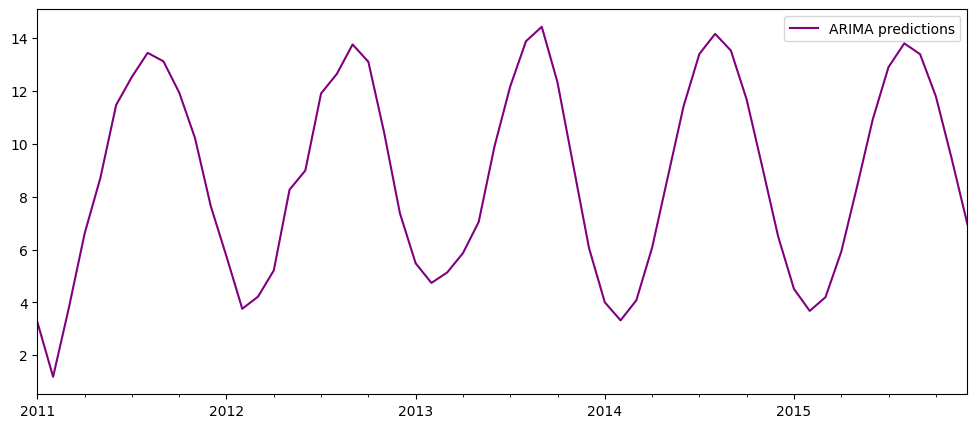

In [ ]:
#Let's view only the ARIMA prediction for United kingdom
preduk_future.plot(figsize=(12,5),legend=True, color ="purple")

In [ ]:
#Printing prediction value for the United Kingdom
print(preduk_future)

2011-01-01     3.256906
2011-02-01     1.183467
2011-03-01     3.795375
2011-04-01     6.606861
2011-05-01     8.711606
2011-06-01    11.470503
2011-07-01    12.536345
2011-08-01    13.443194
2011-09-01    13.122025
2011-10-01    11.940186
2011-11-01    10.222926
2011-12-01     7.648971
2012-01-01     5.735413
2012-02-01     3.757755
2012-03-01     4.215891
2012-04-01     5.209842
2012-05-01     8.264985
2012-06-01     8.988838
2012-07-01    11.907491
2012-08-01    12.644616
2012-09-01    13.760299
2012-10-01    13.104767
2012-11-01    10.429037
2012-12-01     7.376244
2013-01-01     5.479540
2013-02-01     4.735625
2013-03-01     5.130512
2013-04-01     5.862630
2013-05-01     7.042805
2013-06-01     9.897359
2013-07-01    12.173562
2013-08-01    13.883060
2013-09-01    14.429794
2013-10-01    12.324751
2013-11-01     9.184695
2013-12-01     6.052063
2014-01-01     4.002141
2014-02-01     3.318688
2014-03-01     4.077321
2014-04-01     6.065070
2014-05-01     8.751260
2014-06-01    11

**United States forecast for 5 years**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'United States forecast for 5 years')

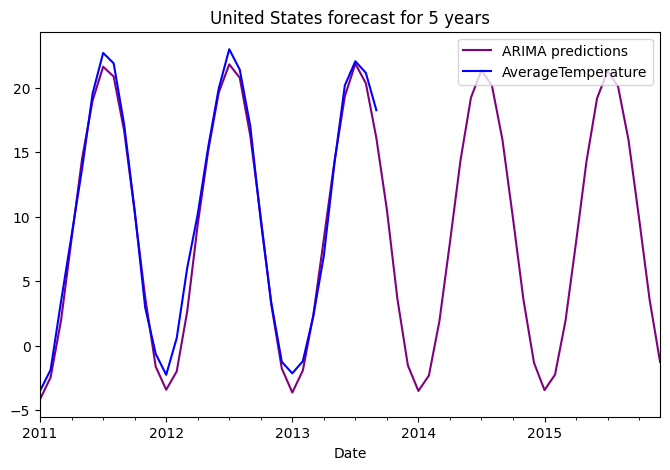

In [ ]:
start=len(dataus_train)
end=len(dataus_train)+len(dataus_test)-1

index_future_usdates=pd.date_range(start='2011-01-01',end='2015-12-01', freq='MS')
predus_future=fitus_ARIMA.predict(start=start, end=end+27, typ='levels').rename('ARIMA predictions')
predus_future.index=index_future_usdates
predus_future.plot(legend=True, color = "purple")
dataus_test['AverageTemperature'].plot(legend=True, color = "blue")
plt.title("United States forecast for 5 years")

United States seems not to have an obvious trends and seasonality over the observed years and the ARIMA prediction predicted the future years without having much difference in the temperature variance over the future years and the observe data.  United States is the coldest country compared to others and it can also be warm towards the month of June, July and August.

<Axes: >

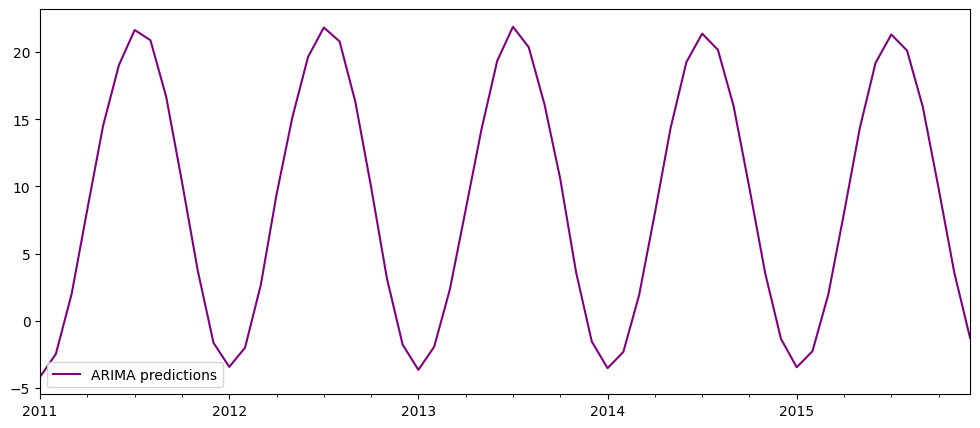

In [ ]:
#Let's view only the ARIMA prediction or United States
predus_future.plot(figsize=(12,5),legend=True, color ="purple")

In [ ]:
#printing the prediction values for US
print(predus_future)

2011-01-01    -4.164445
2011-02-01    -2.468302
2011-03-01     1.993971
2011-04-01     8.324500
2011-05-01    14.536657
2011-06-01    19.029973
2011-07-01    21.646179
2011-08-01    20.886807
2011-09-01    16.674883
2011-10-01    10.350912
2011-11-01     3.749855
2011-12-01    -1.631167
2012-01-01    -3.428312
2012-02-01    -2.005525
2012-03-01     2.659159
2012-04-01     9.395376
2012-05-01    15.130092
2012-06-01    19.643901
2012-07-01    21.832544
2012-08-01    20.792372
2012-09-01    16.299962
2012-10-01     9.951502
2012-11-01     3.177349
2012-12-01    -1.773545
2013-01-01    -3.647062
2013-02-01    -1.936792
2013-03-01     2.360257
2013-04-01     8.270070
2013-05-01    14.242101
2013-06-01    19.351193
2013-07-01    21.886859
2013-08-01    20.362552
2013-09-01    16.109383
2013-10-01    10.557903
2013-11-01     3.637140
2013-12-01    -1.543883
2014-01-01    -3.523454
2014-02-01    -2.319705
2014-03-01     1.899831
2014-04-01     8.002302
2014-05-01    14.351519
2014-06-01    19

**Brazil forecast for 5 years**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Brazil forecast for 5 years')

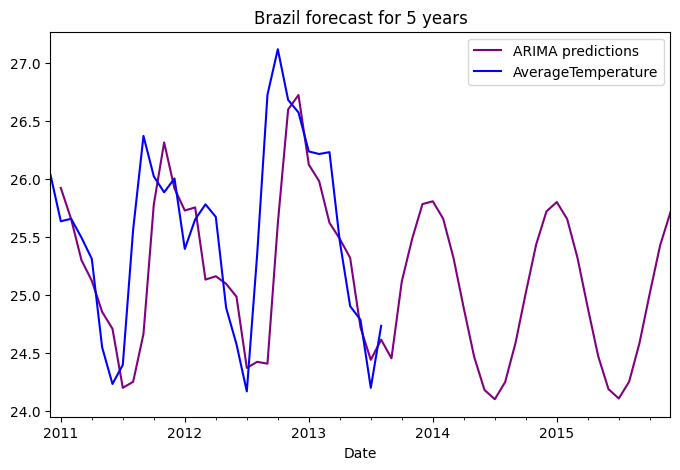

In [ ]:
start=len(databr_train)
end=len(databr_train)+len(databr_test)-1

index_future_brdates=pd.date_range(start='2011-01-01',end='2015-12-01', freq='MS')
predbr_future=fitbr_ARIMA.predict(start=start, end=end+27, typ='levels').rename('ARIMA predictions')
predbr_future.index=index_future_brdates
predbr_future.plot(legend=True, color = "purple")
databr_test['AverageTemperature'].plot(legend=True, color = "blue")
plt.title("Brazil forecast for 5 years")

There is more  temperature trends and seasonality going on in Brazil likewise in Kenya looking at the graphical representation. The model also shows that the temperature change in the future will not have much variation in Brazil.

<Axes: >

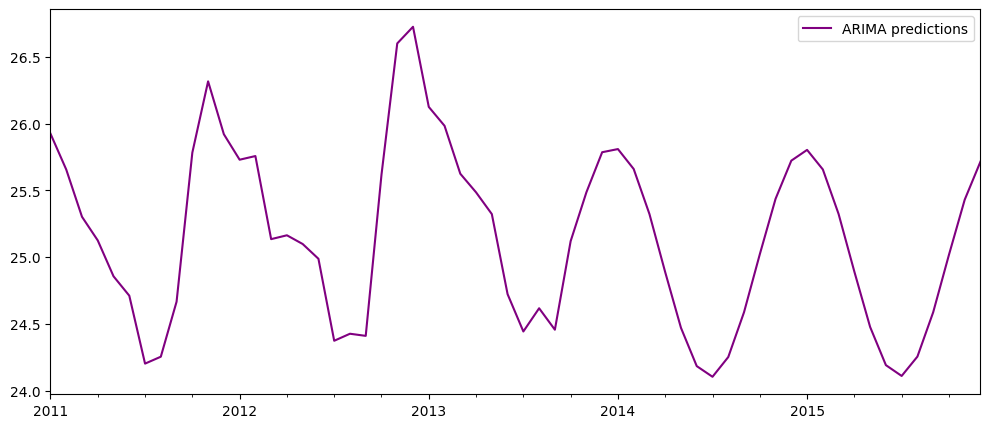

In [ ]:
#Let's view only the ARIMA prediction for Brazil
predbr_future.plot(figsize=(12,5),legend=True, color ="purple")

In [ ]:
#Printing future prediction for Brazil
print(predbr_future)

2011-01-01    25.924857
2011-02-01    25.656009
2011-03-01    25.302083
2011-04-01    25.124819
2011-05-01    24.856320
2011-06-01    24.711053
2011-07-01    24.202166
2011-08-01    24.253948
2011-09-01    24.666037
2011-10-01    25.782614
2011-11-01    26.316436
2011-12-01    25.920417
2012-01-01    25.729587
2012-02-01    25.756951
2012-03-01    25.134619
2012-04-01    25.163460
2012-05-01    25.098112
2012-06-01    24.987561
2012-07-01    24.373353
2012-08-01    24.426016
2012-09-01    24.410061
2012-10-01    25.617129
2012-11-01    26.600602
2012-12-01    26.725267
2013-01-01    26.125160
2013-02-01    25.983451
2013-03-01    25.624456
2013-04-01    25.485099
2013-05-01    25.322301
2013-06-01    24.722333
2013-07-01    24.442893
2013-08-01    24.616806
2013-09-01    24.456278
2013-10-01    25.119529
2013-11-01    25.485599
2013-12-01    25.785664
2014-01-01    25.809241
2014-02-01    25.659969
2014-03-01    25.322316
2014-04-01    24.886826
2014-05-01    24.470091
2014-06-01    24

**Kenya forecast for 5 years**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Kenya forecast for 5 years')

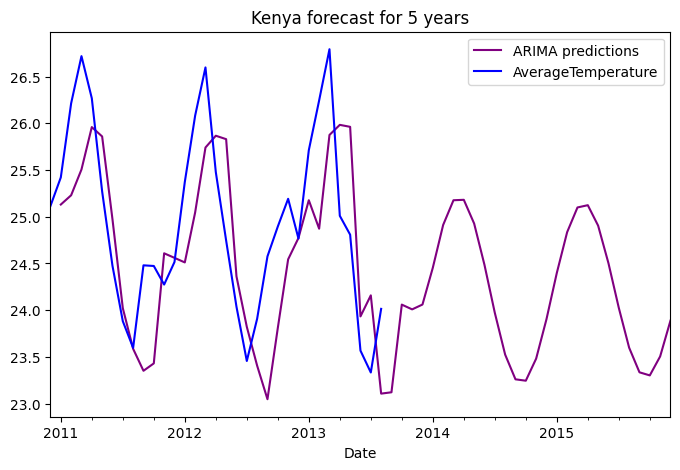

In [ ]:
start=len(dataky_train)
end=len(dataky_train)+len(dataky_test)-1

index_future_kydates=pd.date_range(start='2011-01-01',end='2015-12-01', freq='MS')
predky_future=fitky_ARIMA.predict(start=start, end=end+27, typ='levels').rename('ARIMA predictions')
predky_future.index=index_future_kydates
predky_future.plot(legend=True, color = "purple")
dataky_test['AverageTemperature'].plot(legend=True, color = "blue")
plt.title("Kenya forecast for 5 years")

From this graph, ARIMA prediction shows that Kenya temperature is very warm compared to India, United Kingdom and United States. The lowest temperature is about 23 degree celcius and can feel this low towards July, August or September.Their highest peak is towards the month of March.

<Axes: >

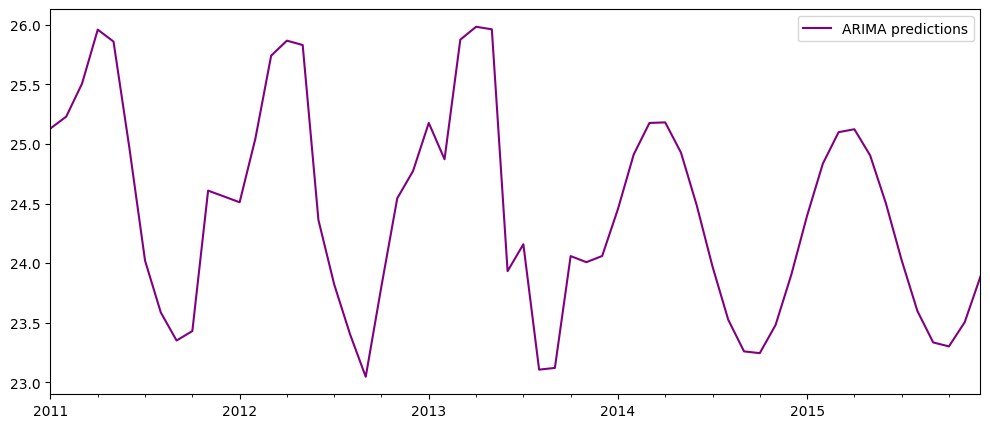

In [ ]:
#Let's view only the ARIMA prediction
predky_future.plot(figsize=(12,5),legend=True, color ="purple")

In [ ]:
#Printing future prediction for Kenya
print(predky_future)

2011-01-01    25.130532
2011-02-01    25.229892
2011-03-01    25.505728
2011-04-01    25.959378
2011-05-01    25.859351
2011-06-01    24.972768
2011-07-01    24.021449
2011-08-01    23.586163
2011-09-01    23.351192
2011-10-01    23.430327
2011-11-01    24.608663
2011-12-01    24.560144
2012-01-01    24.510991
2012-02-01    25.045683
2012-03-01    25.740925
2012-04-01    25.867060
2012-05-01    25.830379
2012-06-01    24.361929
2012-07-01    23.821636
2012-08-01    23.405859
2012-09-01    23.046863
2012-10-01    23.809433
2012-11-01    24.544190
2012-12-01    24.772689
2013-01-01    25.176748
2013-02-01    24.871935
2013-03-01    25.875363
2013-04-01    25.983462
2013-05-01    25.962281
2013-06-01    23.933248
2013-07-01    24.158669
2013-08-01    23.106804
2013-09-01    23.121150
2013-10-01    24.059500
2013-11-01    24.008439
2013-12-01    24.060302
2014-01-01    24.453909
2014-02-01    24.911659
2014-03-01    25.176588
2014-04-01    25.181237
2014-05-01    24.927382
2014-06-01    24

**India forecast for 5 years**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'India forecast for 5 years')

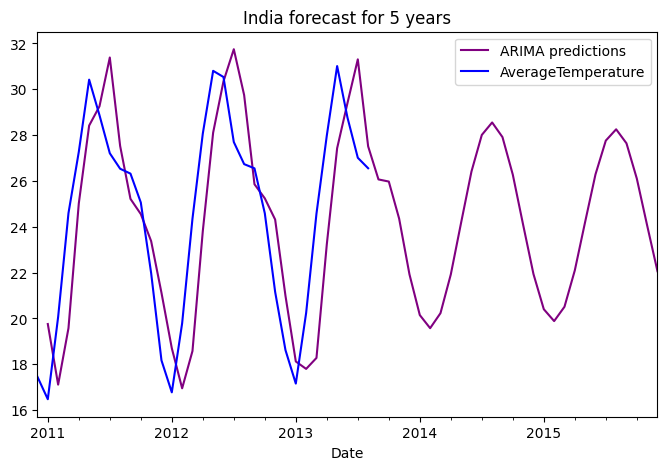

In [ ]:
start=len(dataid_train)
end=len(dataid_train)+len(dataid_test)-1

index_future_iddates=pd.date_range(start='2011-01-01',end='2015-12-01', freq='MS')
predid_future=fitid_ARIMA.predict(start=start, end=end+27, typ='levels').rename('ARIMA predictions')
predid_future.index=index_future_iddates
predid_future.plot(legend=True, color = "purple")
dataid_test['AverageTemperature'].plot(legend=True, color = "blue")
plt.title("India forecast for 5 years")

In India, notice there is a little difference between ARIMA prediction and the observed data. In the observed data the peak of their temperature happens towards the month of May for each year while the ARIMA Prediction, the peak is towards the middle of the year i.e july. However, the future ARIMA prediction changes the peak of the temperature towards the mid-end of the year like August for the future years forecasted. In addition the lowest temperature of India is towards the beginning of the year let's say January and Feburary based on the graph. Notice also that for the future years started increasing in temperature from 2014 which increased from 15 degree to about 17 degree celcius which is also within the range.

<Axes: >

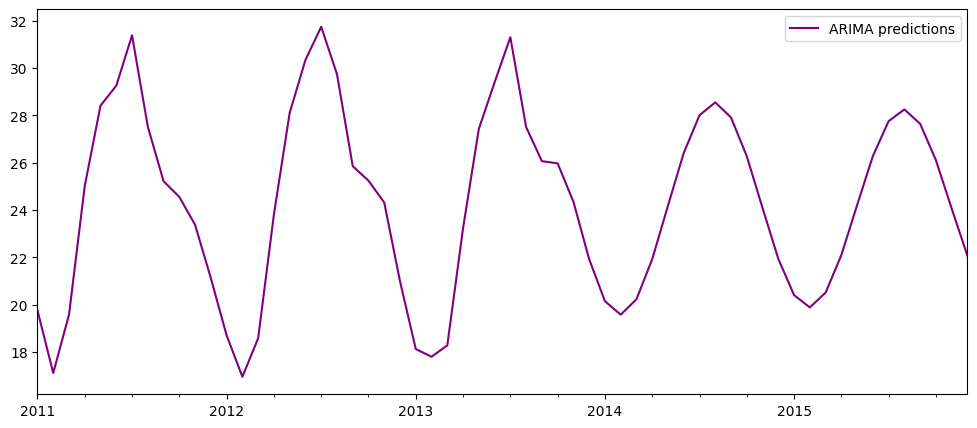

In [ ]:
#Let's view only the ARIMA prediction
predid_future.plot(figsize=(12,5),legend=True, color ="purple")

In [ ]:
#Printing future prediction for India
print(predid_future)

2011-01-01    19.759419
2011-02-01    17.113931
2011-03-01    19.577436
2011-04-01    25.021808
2011-05-01    28.416625
2011-06-01    29.256981
2011-07-01    31.386222
2011-08-01    27.526993
2011-09-01    25.219372
2011-10-01    24.555531
2011-11-01    23.376330
2011-12-01    21.121146
2012-01-01    18.703851
2012-02-01    16.953820
2012-03-01    18.580471
2012-04-01    23.814444
2012-05-01    28.108744
2012-06-01    30.345104
2012-07-01    31.748115
2012-08-01    29.747160
2012-09-01    25.857579
2012-10-01    25.242214
2012-11-01    24.318283
2012-12-01    20.990054
2013-01-01    18.124957
2013-02-01    17.800938
2013-03-01    18.280345
2013-04-01    23.236580
2013-05-01    27.429910
2013-06-01    29.399153
2013-07-01    31.306905
2013-08-01    27.511538
2013-09-01    26.067524
2013-10-01    25.974398
2013-11-01    24.356693
2013-12-01    21.924455
2014-01-01    20.149339
2014-02-01    19.577383
2014-03-01    20.231371
2014-04-01    21.922455
2014-05-01    24.187061
2014-06-01    26

## Summary Result for each country

In [ ]:
#RMSE, MSE FOR UNITED KINGDOM
rmseuk = sqrt(mean_squared_error(pred_uk, datauk_test['AverageTemperature']))
print("RMSE FOR UNITED KINGDOM: ", rmseuk)
mseuk= (mean_squared_error(pred_uk, datauk_test['AverageTemperature']))
print("MSE FOR UNITED KINGDOM: ", mseuk)
mean_df_uk = df_uk["AverageTemperature"].mean()
print("The mean of the model Timeseries: ", mean_df_uk)
Meanuk_datatest = datauk_test["AverageTemperature"].mean()
print("Mean of test data for UK: ", Meanuk_datatest, "\n")

#RMSE, MSE FOR UNITED STATES
rmseus = sqrt(mean_squared_error(pred_us, dataus_test['AverageTemperature']))
print("RMSE FOR UNITED STATES: ", rmseus)
mseus= (mean_squared_error(pred_us, dataus_test['AverageTemperature']))
print("MSE FOR UNITED STATES: ", mseus)
mean_df_us = df_us["AverageTemperature"].mean()
print("The mean of the model Timeseries: ", mean_df_us)
Meanus_datatest = dataus_test["AverageTemperature"].mean()
print("Mean of test data for US: ", Meanus_datatest, "\n")

#RMSE, MSE FOR BRAZIL
rmsebr = sqrt(mean_squared_error(pred_br, databr_test['AverageTemperature']))
print("RMSE FOR BRAZIL: ", rmsebr)
msebr= (mean_squared_error(pred_br, databr_test['AverageTemperature']))
print("MSE FOR BRAZIL: ", msebr)
mean_df_br = df_br["AverageTemperature"].mean()
print("The mean of the model Timeseries: ", mean_df_br)
Meanbr_datatest = databr_test["AverageTemperature"].mean()
print("Mean of test data for Brazil: ", Meanbr_datatest, "\n")

#RMSE, MSE FOR KENYA
rmseky = sqrt(mean_squared_error(pred_ky, dataky_test['AverageTemperature']))
print("RMSE FOR KENYA: ", rmseky)
mseky= (mean_squared_error(pred_ky, dataky_test['AverageTemperature']))
print("MSE FOR KENYA: ", mseky)
mean_df_ky = df_ky["AverageTemperature"].mean()
print("The mean of the model Timeseries: ", mean_df_ky)
Meanky_datatest = dataky_test["AverageTemperature"].mean()
print("Mean of test data for Kenya: ", Meanky_datatest, "\n")

#RMSE, MSE FOR INDIA
rmseid = sqrt(mean_squared_error(pred_id, dataid_test['AverageTemperature']))
print("RMSE FOR INDIA: ", rmseid)
mseid= (mean_squared_error(pred_id, dataid_test['AverageTemperature']))
print("MSE FOR INDIA: ", mseid)
mean_df_id = df_id["AverageTemperature"].mean()
print("The mean of the model Timeseries: ", mean_df_id)
Meanid_datatest = dataid_test["AverageTemperature"].mean()
print("Mean of test data for India: ", Meanid_datatest, "\n")

RMSE FOR UNITED KINGDOM:  1.4757821146547554
MSE FOR UNITED KINGDOM:  2.1779328499348614
The mean of the model Timeseries:  8.770211876832844
Mean of test data for UK:  9.091969696969699 

RMSE FOR UNITED STATES:  1.119812991785622
MSE FOR UNITED STATES:  1.2539811365718658
The mean of the model Timeseries:  8.954234432234433
Mean of test data for US:  10.285030303030304 

RMSE FOR BRAZIL:  0.46298260436869976
MSE FOR BRAZIL:  0.21435289194802398
The mean of the model Timeseries:  24.95352346041056
Mean of test data for Brazil:  25.532575757575756 

RMSE FOR KENYA:  0.5551120785384657
MSE FOR KENYA:  0.30814941973929566
The mean of the model Timeseries:  24.19888929618768
Mean of test data for Kenya:  24.948242424242427 

RMSE FOR INDIA:  1.2350974434109303
MSE FOR INDIA:  1.5254656947202163
The mean of the model Timeseries:  24.149046187683282
Mean of test data for India:  24.528424242424244 



**Documentation**

The overall result of the model carrried out shows that Root Mean Square Error for all countries is approxiately 0.89 error and the Mean Sequared Error for all countries is 0.80. The low value that is close to zero shows how ARIMA Model was able to predict the time series using the past records. The predicted model shows that the temperature variability continues to the future.

The mean of the differenced Timeseries is -0.00099 which indicates the average value of the differences between consecutive time points in the time series data. This means that the vlaues tends to decrease by about 0.001 within the time series points.

Mean of test data: 0.64 is the average value of the actual test data across all countries. It's a baseline measure, which compare the model's predictions to see how well the model is performing.

The above value shows us the RMSE, MSE, MEAN OF THE MODEL and the MEAN of the TEST DATA of each of the countries.

BRAZIL AND KENYA have the least RMSE AND MSE among other countries that shows the accuracy of the model. From this result, it shows how important converting the non-stationarity of time series to stationary. Here, i applied differencing method which converted the time series to stationary. The predicted years have shown that there is a continous temperature variability in the coming years.